In [1]:
# adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/
# https://towardsdatascience.com/pytorch-tutorial-distilled-95ce8781a89c

# 1. Import Modules

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
%matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
# fix random seed for reproducibility
np.random.seed(200184)

# 2. Train the GAN model

In [5]:
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [6]:
# defining classes and ANN
class AE_net(nn.Module):
    def __init__(self):
        super(AE_net, self).__init__()
        #net_list = [nn.Linear(1, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 1),  nn.ReLU()
        #           ]  # definition of model, just put in corresponding layers in sequence
        
        net_list = [nn.Linear(4, 15),   
                    nn.Tanh(),
                    nn.Linear(15, 15), 
                    nn.Tanh(),
                    nn.Linear(15, 2)#, 
#                     nn.Tanh(),
#                     nn.Linear(32, 8),
#                     nn.Tanh(),
#                     nn.Linear(8, 2)
                   ]
        self._net = nn.Sequential(*net_list).to(device)
        return

    def forward(self, x):
        return self._net(x)
    
def get_var_from_np(np_array, cuda=False, requires_grad=False):    # convert numpy to PyTorch variable for training
    temp = Variable(torch.from_numpy(np_array), requires_grad=requires_grad).type(torch.FloatTensor)
    if cuda: temp = temp.cuda()
    return temp
    
def train(model, data_in, data_out, data_in_val, data_out_val):
    
    train_data = My_dataset(get_var_from_np(data_in), get_var_from_np(data_out))
    val_data = My_dataset(get_var_from_np(data_in_val), get_var_from_np(data_out_val))
    
    optimizer = torch.optim.SGD(model._net.parameters(), lr = 0.01, momentum=0.9)
    n_epoch = 3000
    batch_size = 100
    n_batch = math.ceil(1. * len(train_data) / batch_size)
    loss_train = np.zeros(n_epoch)
    loss_val = np.zeros(n_epoch)
    
    for epoch in range(n_epoch):    
        
        dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
        
        batch_idx = 0
        for train_in, train_out in dataset:
            out = model._net.forward(train_in)
            loss = nn.MSELoss()(out, train_out) 
            if (batch_idx+1) % min(10,n_batch) == 0:
                print ("Epoch = %5d, Batch = %5d/%5d [%4.0f%%]:\tTraining Loss = %12.5e" % (epoch, batch_idx+1, n_batch, 100. * (batch_idx+1) / n_batch, loss.cpu().data.numpy()))
            optimizer.zero_grad()
            loss.backward() # scalar variables, when we call .backward() on them, don’t require arguments – only tensors require a matching sized tensor argument to be passed to the .backward() operation
            optimizer.step()
            del loss
            batch_idx += 1
        
        data_out_pred = model._net.forward(get_var_from_np(data_in)).cpu().data.numpy()
        diff = data_out_pred - data_out
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_train[epoch] = MSE
        
        data_out_val_pred = model._net.forward(get_var_from_np(data_in_val)).cpu().data.numpy()
        diff = data_out_val_pred - data_out_val
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_val[epoch] = MSE        

    return loss_train, loss_val
    
class My_dataset(Dataset):      # construct dataset object for mini-batch gradient descent
    def __init__(self, data_in, data_out):
        self._data_in = data_in
        self._data_out = data_out

    def __len__(self):
        return len(self._data_in)

    def __getitem__(self, index):
        return self._data_in[index], self._data_out[index]

In [7]:
EBD = np.loadtxt("pivot_nystrom_ebd.txt",delimiter=' ')[:,1:5]
X = np.loadtxt("pivot_nystrom_x_10.txt",delimiter=' ')[:,0:2]

In [8]:
n = X.shape[0]

x = np.concatenate((EBD[:,0].reshape(EBD.shape[0],1), EBD[:,1].reshape(EBD.shape[0],1),EBD[:,2].reshape(EBD.shape[0],1),EBD[:,3].reshape(EBD.shape[0],1)), axis=1)

print (x)

[[ 0.00560742  0.00726292  0.00140773 -0.01042398]
 [ 0.0043122   0.01036681 -0.00152836 -0.00875763]
 [ 0.00591439  0.00564227 -0.00362416 -0.0114559 ]
 ...
 [-0.00239347  0.00695286 -0.00428957  0.00375815]
 [-0.00496246  0.00567255 -0.00535445  0.00690639]
 [-0.00813826  0.00140413 -0.00984598  0.00974406]]


In [9]:
y = np.zeros((n,2))

y = np.concatenate((X[:,0].reshape(X.shape[0],1), X[:,1].reshape(X.shape[0],1)), axis=1)

print (y)

[[-0.00562984  0.00216394]
 [-0.00644251  0.00639359]
 [-0.00720741  0.01009581]
 ...
 [-0.00900331  0.02090555]
 [-0.00849093  0.01784405]
 [-0.00885909  0.01938939]]


In [10]:
test_frac = 0.10
val_frac = 0.20
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=test_frac, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_frac/(1-test_frac), random_state=43)

In [11]:
# scaling
xscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling
yscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling

# xscale = pre.StandardScaler()
# yscale = pre.StandardScaler()


X_train = xscale.fit_transform(x_train)
Y_train = yscale.fit_transform(y_train)
X_val = xscale.transform(x_val)
Y_val = yscale.transform(y_val)
X_test = xscale.transform(x_test)
Y_test = yscale.transform(y_test)
X = xscale.transform(x)
Y = yscale.transform(y)

In [12]:
# training
model = AE_net()
print(model)

AE_net(
  (_net): Sequential(
    (0): Linear(in_features=4, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=2, bias=True)
  )
)


In [13]:
loss_train, loss_val = train(model, X_train, Y_train, X_val, Y_val)

Epoch =     0, Batch =    10/   35 [  29%]:	Training Loss =  5.00675e-02
Epoch =     0, Batch =    20/   35 [  57%]:	Training Loss =  5.37183e-02
Epoch =     0, Batch =    30/   35 [  86%]:	Training Loss =  4.62100e-02
Epoch =     1, Batch =    10/   35 [  29%]:	Training Loss =  5.67872e-02
Epoch =     1, Batch =    20/   35 [  57%]:	Training Loss =  4.90202e-02
Epoch =     1, Batch =    30/   35 [  86%]:	Training Loss =  5.61756e-02
Epoch =     2, Batch =    10/   35 [  29%]:	Training Loss =  3.97333e-02
Epoch =     2, Batch =    20/   35 [  57%]:	Training Loss =  4.72901e-02
Epoch =     2, Batch =    30/   35 [  86%]:	Training Loss =  4.88506e-02
Epoch =     3, Batch =    10/   35 [  29%]:	Training Loss =  5.00265e-02
Epoch =     3, Batch =    20/   35 [  57%]:	Training Loss =  5.59732e-02
Epoch =     3, Batch =    30/   35 [  86%]:	Training Loss =  6.04135e-02
Epoch =     4, Batch =    10/   35 [  29%]:	Training Loss =  4.80584e-02
Epoch =     4, Batch =    20/   35 [  57%]:	Trainin

Epoch =    38, Batch =    30/   35 [  86%]:	Training Loss =  4.73378e-02
Epoch =    39, Batch =    10/   35 [  29%]:	Training Loss =  3.83016e-02
Epoch =    39, Batch =    20/   35 [  57%]:	Training Loss =  3.27532e-02
Epoch =    39, Batch =    30/   35 [  86%]:	Training Loss =  4.28369e-02
Epoch =    40, Batch =    10/   35 [  29%]:	Training Loss =  3.89494e-02
Epoch =    40, Batch =    20/   35 [  57%]:	Training Loss =  3.37671e-02
Epoch =    40, Batch =    30/   35 [  86%]:	Training Loss =  4.24289e-02
Epoch =    41, Batch =    10/   35 [  29%]:	Training Loss =  4.14927e-02
Epoch =    41, Batch =    20/   35 [  57%]:	Training Loss =  4.59696e-02
Epoch =    41, Batch =    30/   35 [  86%]:	Training Loss =  4.54384e-02
Epoch =    42, Batch =    10/   35 [  29%]:	Training Loss =  4.54778e-02
Epoch =    42, Batch =    20/   35 [  57%]:	Training Loss =  4.28909e-02
Epoch =    42, Batch =    30/   35 [  86%]:	Training Loss =  3.45446e-02
Epoch =    43, Batch =    10/   35 [  29%]:	Trainin

Epoch =    76, Batch =    30/   35 [  86%]:	Training Loss =  3.12719e-02
Epoch =    77, Batch =    10/   35 [  29%]:	Training Loss =  4.07408e-02
Epoch =    77, Batch =    20/   35 [  57%]:	Training Loss =  3.72752e-02
Epoch =    77, Batch =    30/   35 [  86%]:	Training Loss =  3.57960e-02
Epoch =    78, Batch =    10/   35 [  29%]:	Training Loss =  4.55767e-02
Epoch =    78, Batch =    20/   35 [  57%]:	Training Loss =  4.24836e-02
Epoch =    78, Batch =    30/   35 [  86%]:	Training Loss =  4.65187e-02
Epoch =    79, Batch =    10/   35 [  29%]:	Training Loss =  3.90456e-02
Epoch =    79, Batch =    20/   35 [  57%]:	Training Loss =  3.24274e-02
Epoch =    79, Batch =    30/   35 [  86%]:	Training Loss =  4.21332e-02
Epoch =    80, Batch =    10/   35 [  29%]:	Training Loss =  5.87531e-02
Epoch =    80, Batch =    20/   35 [  57%]:	Training Loss =  3.42626e-02
Epoch =    80, Batch =    30/   35 [  86%]:	Training Loss =  4.20066e-02
Epoch =    81, Batch =    10/   35 [  29%]:	Trainin

Epoch =   116, Batch =    20/   35 [  57%]:	Training Loss =  3.10208e-02
Epoch =   116, Batch =    30/   35 [  86%]:	Training Loss =  3.60401e-02
Epoch =   117, Batch =    10/   35 [  29%]:	Training Loss =  4.62438e-02
Epoch =   117, Batch =    20/   35 [  57%]:	Training Loss =  4.83530e-02
Epoch =   117, Batch =    30/   35 [  86%]:	Training Loss =  4.04786e-02
Epoch =   118, Batch =    10/   35 [  29%]:	Training Loss =  4.37303e-02
Epoch =   118, Batch =    20/   35 [  57%]:	Training Loss =  4.79118e-02
Epoch =   118, Batch =    30/   35 [  86%]:	Training Loss =  5.05682e-02
Epoch =   119, Batch =    10/   35 [  29%]:	Training Loss =  3.47835e-02
Epoch =   119, Batch =    20/   35 [  57%]:	Training Loss =  4.30995e-02
Epoch =   119, Batch =    30/   35 [  86%]:	Training Loss =  4.00101e-02
Epoch =   120, Batch =    10/   35 [  29%]:	Training Loss =  6.25966e-02
Epoch =   120, Batch =    20/   35 [  57%]:	Training Loss =  5.03772e-02
Epoch =   120, Batch =    30/   35 [  86%]:	Trainin

Epoch =   155, Batch =    20/   35 [  57%]:	Training Loss =  4.42647e-02
Epoch =   155, Batch =    30/   35 [  86%]:	Training Loss =  4.72349e-02
Epoch =   156, Batch =    10/   35 [  29%]:	Training Loss =  4.29467e-02
Epoch =   156, Batch =    20/   35 [  57%]:	Training Loss =  3.62299e-02
Epoch =   156, Batch =    30/   35 [  86%]:	Training Loss =  5.54695e-02
Epoch =   157, Batch =    10/   35 [  29%]:	Training Loss =  4.64775e-02
Epoch =   157, Batch =    20/   35 [  57%]:	Training Loss =  4.55279e-02
Epoch =   157, Batch =    30/   35 [  86%]:	Training Loss =  4.32295e-02
Epoch =   158, Batch =    10/   35 [  29%]:	Training Loss =  4.25843e-02
Epoch =   158, Batch =    20/   35 [  57%]:	Training Loss =  3.43617e-02
Epoch =   158, Batch =    30/   35 [  86%]:	Training Loss =  5.59067e-02
Epoch =   159, Batch =    10/   35 [  29%]:	Training Loss =  4.17768e-02
Epoch =   159, Batch =    20/   35 [  57%]:	Training Loss =  4.29868e-02
Epoch =   159, Batch =    30/   35 [  86%]:	Trainin

Epoch =   195, Batch =    10/   35 [  29%]:	Training Loss =  4.78167e-02
Epoch =   195, Batch =    20/   35 [  57%]:	Training Loss =  5.24575e-02
Epoch =   195, Batch =    30/   35 [  86%]:	Training Loss =  4.18359e-02
Epoch =   196, Batch =    10/   35 [  29%]:	Training Loss =  5.00150e-02
Epoch =   196, Batch =    20/   35 [  57%]:	Training Loss =  3.81820e-02
Epoch =   196, Batch =    30/   35 [  86%]:	Training Loss =  4.68446e-02
Epoch =   197, Batch =    10/   35 [  29%]:	Training Loss =  4.05243e-02
Epoch =   197, Batch =    20/   35 [  57%]:	Training Loss =  5.40016e-02
Epoch =   197, Batch =    30/   35 [  86%]:	Training Loss =  4.59740e-02
Epoch =   198, Batch =    10/   35 [  29%]:	Training Loss =  4.36725e-02
Epoch =   198, Batch =    20/   35 [  57%]:	Training Loss =  4.58909e-02
Epoch =   198, Batch =    30/   35 [  86%]:	Training Loss =  3.76405e-02
Epoch =   199, Batch =    10/   35 [  29%]:	Training Loss =  4.79057e-02
Epoch =   199, Batch =    20/   35 [  57%]:	Trainin

Epoch =   233, Batch =    30/   35 [  86%]:	Training Loss =  3.21461e-02
Epoch =   234, Batch =    10/   35 [  29%]:	Training Loss =  4.35569e-02
Epoch =   234, Batch =    20/   35 [  57%]:	Training Loss =  2.96103e-02
Epoch =   234, Batch =    30/   35 [  86%]:	Training Loss =  2.95708e-02
Epoch =   235, Batch =    10/   35 [  29%]:	Training Loss =  3.89082e-02
Epoch =   235, Batch =    20/   35 [  57%]:	Training Loss =  3.56984e-02
Epoch =   235, Batch =    30/   35 [  86%]:	Training Loss =  3.71113e-02
Epoch =   236, Batch =    10/   35 [  29%]:	Training Loss =  4.21146e-02
Epoch =   236, Batch =    20/   35 [  57%]:	Training Loss =  4.18584e-02
Epoch =   236, Batch =    30/   35 [  86%]:	Training Loss =  3.02107e-02
Epoch =   237, Batch =    10/   35 [  29%]:	Training Loss =  3.88082e-02
Epoch =   237, Batch =    20/   35 [  57%]:	Training Loss =  5.81912e-02
Epoch =   237, Batch =    30/   35 [  86%]:	Training Loss =  4.67040e-02
Epoch =   238, Batch =    10/   35 [  29%]:	Trainin

Epoch =   271, Batch =    20/   35 [  57%]:	Training Loss =  5.73408e-02
Epoch =   271, Batch =    30/   35 [  86%]:	Training Loss =  3.99765e-02
Epoch =   272, Batch =    10/   35 [  29%]:	Training Loss =  2.73088e-02
Epoch =   272, Batch =    20/   35 [  57%]:	Training Loss =  3.53054e-02
Epoch =   272, Batch =    30/   35 [  86%]:	Training Loss =  3.85271e-02
Epoch =   273, Batch =    10/   35 [  29%]:	Training Loss =  4.11199e-02
Epoch =   273, Batch =    20/   35 [  57%]:	Training Loss =  3.85586e-02
Epoch =   273, Batch =    30/   35 [  86%]:	Training Loss =  4.32156e-02
Epoch =   274, Batch =    10/   35 [  29%]:	Training Loss =  4.30938e-02
Epoch =   274, Batch =    20/   35 [  57%]:	Training Loss =  4.66118e-02
Epoch =   274, Batch =    30/   35 [  86%]:	Training Loss =  3.88710e-02
Epoch =   275, Batch =    10/   35 [  29%]:	Training Loss =  3.60379e-02
Epoch =   275, Batch =    20/   35 [  57%]:	Training Loss =  3.87645e-02
Epoch =   275, Batch =    30/   35 [  86%]:	Trainin

Epoch =   309, Batch =    10/   35 [  29%]:	Training Loss =  4.01238e-02
Epoch =   309, Batch =    20/   35 [  57%]:	Training Loss =  3.49727e-02
Epoch =   309, Batch =    30/   35 [  86%]:	Training Loss =  4.26142e-02
Epoch =   310, Batch =    10/   35 [  29%]:	Training Loss =  3.85419e-02
Epoch =   310, Batch =    20/   35 [  57%]:	Training Loss =  4.22474e-02
Epoch =   310, Batch =    30/   35 [  86%]:	Training Loss =  4.15914e-02
Epoch =   311, Batch =    10/   35 [  29%]:	Training Loss =  4.35224e-02
Epoch =   311, Batch =    20/   35 [  57%]:	Training Loss =  3.16233e-02
Epoch =   311, Batch =    30/   35 [  86%]:	Training Loss =  4.63656e-02
Epoch =   312, Batch =    10/   35 [  29%]:	Training Loss =  5.27155e-02
Epoch =   312, Batch =    20/   35 [  57%]:	Training Loss =  2.13941e-02
Epoch =   312, Batch =    30/   35 [  86%]:	Training Loss =  4.80827e-02
Epoch =   313, Batch =    10/   35 [  29%]:	Training Loss =  4.77214e-02
Epoch =   313, Batch =    20/   35 [  57%]:	Trainin

Epoch =   346, Batch =    30/   35 [  86%]:	Training Loss =  4.11133e-02
Epoch =   347, Batch =    10/   35 [  29%]:	Training Loss =  3.32824e-02
Epoch =   347, Batch =    20/   35 [  57%]:	Training Loss =  4.41306e-02
Epoch =   347, Batch =    30/   35 [  86%]:	Training Loss =  3.03667e-02
Epoch =   348, Batch =    10/   35 [  29%]:	Training Loss =  3.90448e-02
Epoch =   348, Batch =    20/   35 [  57%]:	Training Loss =  3.54229e-02
Epoch =   348, Batch =    30/   35 [  86%]:	Training Loss =  3.04894e-02
Epoch =   349, Batch =    10/   35 [  29%]:	Training Loss =  3.07883e-02
Epoch =   349, Batch =    20/   35 [  57%]:	Training Loss =  4.37664e-02
Epoch =   349, Batch =    30/   35 [  86%]:	Training Loss =  3.18611e-02
Epoch =   350, Batch =    10/   35 [  29%]:	Training Loss =  4.75130e-02
Epoch =   350, Batch =    20/   35 [  57%]:	Training Loss =  2.87422e-02
Epoch =   350, Batch =    30/   35 [  86%]:	Training Loss =  3.78492e-02
Epoch =   351, Batch =    10/   35 [  29%]:	Trainin

Epoch =   386, Batch =    20/   35 [  57%]:	Training Loss =  3.10151e-02
Epoch =   386, Batch =    30/   35 [  86%]:	Training Loss =  3.93383e-02
Epoch =   387, Batch =    10/   35 [  29%]:	Training Loss =  3.73788e-02
Epoch =   387, Batch =    20/   35 [  57%]:	Training Loss =  3.97208e-02
Epoch =   387, Batch =    30/   35 [  86%]:	Training Loss =  3.34941e-02
Epoch =   388, Batch =    10/   35 [  29%]:	Training Loss =  3.21991e-02
Epoch =   388, Batch =    20/   35 [  57%]:	Training Loss =  3.30742e-02
Epoch =   388, Batch =    30/   35 [  86%]:	Training Loss =  3.54292e-02
Epoch =   389, Batch =    10/   35 [  29%]:	Training Loss =  3.95184e-02
Epoch =   389, Batch =    20/   35 [  57%]:	Training Loss =  3.78846e-02
Epoch =   389, Batch =    30/   35 [  86%]:	Training Loss =  3.75884e-02
Epoch =   390, Batch =    10/   35 [  29%]:	Training Loss =  3.45687e-02
Epoch =   390, Batch =    20/   35 [  57%]:	Training Loss =  3.08631e-02
Epoch =   390, Batch =    30/   35 [  86%]:	Trainin

Epoch =   425, Batch =    10/   35 [  29%]:	Training Loss =  3.38139e-02
Epoch =   425, Batch =    20/   35 [  57%]:	Training Loss =  3.07351e-02
Epoch =   425, Batch =    30/   35 [  86%]:	Training Loss =  3.41932e-02
Epoch =   426, Batch =    10/   35 [  29%]:	Training Loss =  3.77606e-02
Epoch =   426, Batch =    20/   35 [  57%]:	Training Loss =  3.69125e-02
Epoch =   426, Batch =    30/   35 [  86%]:	Training Loss =  6.10207e-02
Epoch =   427, Batch =    10/   35 [  29%]:	Training Loss =  3.62547e-02
Epoch =   427, Batch =    20/   35 [  57%]:	Training Loss =  2.04948e-02
Epoch =   427, Batch =    30/   35 [  86%]:	Training Loss =  3.59363e-02
Epoch =   428, Batch =    10/   35 [  29%]:	Training Loss =  2.91292e-02
Epoch =   428, Batch =    20/   35 [  57%]:	Training Loss =  3.88693e-02
Epoch =   428, Batch =    30/   35 [  86%]:	Training Loss =  3.25876e-02
Epoch =   429, Batch =    10/   35 [  29%]:	Training Loss =  2.86180e-02
Epoch =   429, Batch =    20/   35 [  57%]:	Trainin

Epoch =   462, Batch =    30/   35 [  86%]:	Training Loss =  3.71853e-02
Epoch =   463, Batch =    10/   35 [  29%]:	Training Loss =  3.38696e-02
Epoch =   463, Batch =    20/   35 [  57%]:	Training Loss =  3.09770e-02
Epoch =   463, Batch =    30/   35 [  86%]:	Training Loss =  3.00401e-02
Epoch =   464, Batch =    10/   35 [  29%]:	Training Loss =  3.01777e-02
Epoch =   464, Batch =    20/   35 [  57%]:	Training Loss =  3.39326e-02
Epoch =   464, Batch =    30/   35 [  86%]:	Training Loss =  3.09504e-02
Epoch =   465, Batch =    10/   35 [  29%]:	Training Loss =  4.00842e-02
Epoch =   465, Batch =    20/   35 [  57%]:	Training Loss =  4.80806e-02
Epoch =   465, Batch =    30/   35 [  86%]:	Training Loss =  2.83557e-02
Epoch =   466, Batch =    10/   35 [  29%]:	Training Loss =  2.79986e-02
Epoch =   466, Batch =    20/   35 [  57%]:	Training Loss =  4.00413e-02
Epoch =   466, Batch =    30/   35 [  86%]:	Training Loss =  3.40931e-02
Epoch =   467, Batch =    10/   35 [  29%]:	Trainin

Epoch =   501, Batch =    20/   35 [  57%]:	Training Loss =  3.71844e-02
Epoch =   501, Batch =    30/   35 [  86%]:	Training Loss =  4.23776e-02
Epoch =   502, Batch =    10/   35 [  29%]:	Training Loss =  3.96860e-02
Epoch =   502, Batch =    20/   35 [  57%]:	Training Loss =  3.71293e-02
Epoch =   502, Batch =    30/   35 [  86%]:	Training Loss =  4.80883e-02
Epoch =   503, Batch =    10/   35 [  29%]:	Training Loss =  4.31819e-02
Epoch =   503, Batch =    20/   35 [  57%]:	Training Loss =  3.39391e-02
Epoch =   503, Batch =    30/   35 [  86%]:	Training Loss =  4.30656e-02
Epoch =   504, Batch =    10/   35 [  29%]:	Training Loss =  3.30012e-02
Epoch =   504, Batch =    20/   35 [  57%]:	Training Loss =  3.39114e-02
Epoch =   504, Batch =    30/   35 [  86%]:	Training Loss =  4.32126e-02
Epoch =   505, Batch =    10/   35 [  29%]:	Training Loss =  2.51462e-02
Epoch =   505, Batch =    20/   35 [  57%]:	Training Loss =  3.27368e-02
Epoch =   505, Batch =    30/   35 [  86%]:	Trainin

Epoch =   542, Batch =    10/   35 [  29%]:	Training Loss =  3.83891e-02
Epoch =   542, Batch =    20/   35 [  57%]:	Training Loss =  3.11757e-02
Epoch =   542, Batch =    30/   35 [  86%]:	Training Loss =  3.52134e-02
Epoch =   543, Batch =    10/   35 [  29%]:	Training Loss =  2.85259e-02
Epoch =   543, Batch =    20/   35 [  57%]:	Training Loss =  3.64938e-02
Epoch =   543, Batch =    30/   35 [  86%]:	Training Loss =  4.88314e-02
Epoch =   544, Batch =    10/   35 [  29%]:	Training Loss =  3.67446e-02
Epoch =   544, Batch =    20/   35 [  57%]:	Training Loss =  4.30476e-02
Epoch =   544, Batch =    30/   35 [  86%]:	Training Loss =  4.07779e-02
Epoch =   545, Batch =    10/   35 [  29%]:	Training Loss =  2.65316e-02
Epoch =   545, Batch =    20/   35 [  57%]:	Training Loss =  3.54186e-02
Epoch =   545, Batch =    30/   35 [  86%]:	Training Loss =  3.60118e-02
Epoch =   546, Batch =    10/   35 [  29%]:	Training Loss =  3.70827e-02
Epoch =   546, Batch =    20/   35 [  57%]:	Trainin

Epoch =   581, Batch =    10/   35 [  29%]:	Training Loss =  4.24919e-02
Epoch =   581, Batch =    20/   35 [  57%]:	Training Loss =  3.45749e-02
Epoch =   581, Batch =    30/   35 [  86%]:	Training Loss =  3.90843e-02
Epoch =   582, Batch =    10/   35 [  29%]:	Training Loss =  4.09784e-02
Epoch =   582, Batch =    20/   35 [  57%]:	Training Loss =  3.86485e-02
Epoch =   582, Batch =    30/   35 [  86%]:	Training Loss =  4.34718e-02
Epoch =   583, Batch =    10/   35 [  29%]:	Training Loss =  2.76703e-02
Epoch =   583, Batch =    20/   35 [  57%]:	Training Loss =  3.97968e-02
Epoch =   583, Batch =    30/   35 [  86%]:	Training Loss =  2.96966e-02
Epoch =   584, Batch =    10/   35 [  29%]:	Training Loss =  2.99684e-02
Epoch =   584, Batch =    20/   35 [  57%]:	Training Loss =  3.06348e-02
Epoch =   584, Batch =    30/   35 [  86%]:	Training Loss =  3.25689e-02
Epoch =   585, Batch =    10/   35 [  29%]:	Training Loss =  3.89690e-02
Epoch =   585, Batch =    20/   35 [  57%]:	Trainin

Epoch =   621, Batch =    10/   35 [  29%]:	Training Loss =  3.82185e-02
Epoch =   621, Batch =    20/   35 [  57%]:	Training Loss =  4.34152e-02
Epoch =   621, Batch =    30/   35 [  86%]:	Training Loss =  3.72144e-02
Epoch =   622, Batch =    10/   35 [  29%]:	Training Loss =  3.57897e-02
Epoch =   622, Batch =    20/   35 [  57%]:	Training Loss =  2.45720e-02
Epoch =   622, Batch =    30/   35 [  86%]:	Training Loss =  4.62050e-02
Epoch =   623, Batch =    10/   35 [  29%]:	Training Loss =  3.58302e-02
Epoch =   623, Batch =    20/   35 [  57%]:	Training Loss =  3.63574e-02
Epoch =   623, Batch =    30/   35 [  86%]:	Training Loss =  3.32841e-02
Epoch =   624, Batch =    10/   35 [  29%]:	Training Loss =  3.12845e-02
Epoch =   624, Batch =    20/   35 [  57%]:	Training Loss =  3.84059e-02
Epoch =   624, Batch =    30/   35 [  86%]:	Training Loss =  2.68612e-02
Epoch =   625, Batch =    10/   35 [  29%]:	Training Loss =  3.23108e-02
Epoch =   625, Batch =    20/   35 [  57%]:	Trainin

Epoch =   662, Batch =    20/   35 [  57%]:	Training Loss =  3.36465e-02
Epoch =   662, Batch =    30/   35 [  86%]:	Training Loss =  3.24405e-02
Epoch =   663, Batch =    10/   35 [  29%]:	Training Loss =  3.47931e-02
Epoch =   663, Batch =    20/   35 [  57%]:	Training Loss =  3.46098e-02
Epoch =   663, Batch =    30/   35 [  86%]:	Training Loss =  2.84064e-02
Epoch =   664, Batch =    10/   35 [  29%]:	Training Loss =  3.32939e-02
Epoch =   664, Batch =    20/   35 [  57%]:	Training Loss =  2.91202e-02
Epoch =   664, Batch =    30/   35 [  86%]:	Training Loss =  4.80461e-02
Epoch =   665, Batch =    10/   35 [  29%]:	Training Loss =  3.00443e-02
Epoch =   665, Batch =    20/   35 [  57%]:	Training Loss =  2.74952e-02
Epoch =   665, Batch =    30/   35 [  86%]:	Training Loss =  2.85121e-02
Epoch =   666, Batch =    10/   35 [  29%]:	Training Loss =  3.36063e-02
Epoch =   666, Batch =    20/   35 [  57%]:	Training Loss =  4.19649e-02
Epoch =   666, Batch =    30/   35 [  86%]:	Trainin

Epoch =   701, Batch =    10/   35 [  29%]:	Training Loss =  3.76544e-02
Epoch =   701, Batch =    20/   35 [  57%]:	Training Loss =  4.07530e-02
Epoch =   701, Batch =    30/   35 [  86%]:	Training Loss =  3.12299e-02
Epoch =   702, Batch =    10/   35 [  29%]:	Training Loss =  3.35859e-02
Epoch =   702, Batch =    20/   35 [  57%]:	Training Loss =  3.99634e-02
Epoch =   702, Batch =    30/   35 [  86%]:	Training Loss =  3.20019e-02
Epoch =   703, Batch =    10/   35 [  29%]:	Training Loss =  4.46292e-02
Epoch =   703, Batch =    20/   35 [  57%]:	Training Loss =  2.81583e-02
Epoch =   703, Batch =    30/   35 [  86%]:	Training Loss =  2.00654e-02
Epoch =   704, Batch =    10/   35 [  29%]:	Training Loss =  3.26413e-02
Epoch =   704, Batch =    20/   35 [  57%]:	Training Loss =  3.52603e-02
Epoch =   704, Batch =    30/   35 [  86%]:	Training Loss =  3.14586e-02
Epoch =   705, Batch =    10/   35 [  29%]:	Training Loss =  4.43999e-02
Epoch =   705, Batch =    20/   35 [  57%]:	Trainin

Epoch =   742, Batch =    30/   35 [  86%]:	Training Loss =  2.98431e-02
Epoch =   743, Batch =    10/   35 [  29%]:	Training Loss =  3.25934e-02
Epoch =   743, Batch =    20/   35 [  57%]:	Training Loss =  3.14997e-02
Epoch =   743, Batch =    30/   35 [  86%]:	Training Loss =  2.28713e-02
Epoch =   744, Batch =    10/   35 [  29%]:	Training Loss =  4.81481e-02
Epoch =   744, Batch =    20/   35 [  57%]:	Training Loss =  4.00918e-02
Epoch =   744, Batch =    30/   35 [  86%]:	Training Loss =  3.65883e-02
Epoch =   745, Batch =    10/   35 [  29%]:	Training Loss =  4.16322e-02
Epoch =   745, Batch =    20/   35 [  57%]:	Training Loss =  4.30601e-02
Epoch =   745, Batch =    30/   35 [  86%]:	Training Loss =  3.50560e-02
Epoch =   746, Batch =    10/   35 [  29%]:	Training Loss =  5.04174e-02
Epoch =   746, Batch =    20/   35 [  57%]:	Training Loss =  3.48437e-02
Epoch =   746, Batch =    30/   35 [  86%]:	Training Loss =  3.93373e-02
Epoch =   747, Batch =    10/   35 [  29%]:	Trainin

Epoch =   784, Batch =    20/   35 [  57%]:	Training Loss =  3.57305e-02
Epoch =   784, Batch =    30/   35 [  86%]:	Training Loss =  3.56754e-02
Epoch =   785, Batch =    10/   35 [  29%]:	Training Loss =  3.04465e-02
Epoch =   785, Batch =    20/   35 [  57%]:	Training Loss =  2.88155e-02
Epoch =   785, Batch =    30/   35 [  86%]:	Training Loss =  4.21667e-02
Epoch =   786, Batch =    10/   35 [  29%]:	Training Loss =  3.50771e-02
Epoch =   786, Batch =    20/   35 [  57%]:	Training Loss =  2.16354e-02
Epoch =   786, Batch =    30/   35 [  86%]:	Training Loss =  2.80573e-02
Epoch =   787, Batch =    10/   35 [  29%]:	Training Loss =  3.35873e-02
Epoch =   787, Batch =    20/   35 [  57%]:	Training Loss =  4.06771e-02
Epoch =   787, Batch =    30/   35 [  86%]:	Training Loss =  3.37561e-02
Epoch =   788, Batch =    10/   35 [  29%]:	Training Loss =  3.01893e-02
Epoch =   788, Batch =    20/   35 [  57%]:	Training Loss =  3.70812e-02
Epoch =   788, Batch =    30/   35 [  86%]:	Trainin

Epoch =   822, Batch =    10/   35 [  29%]:	Training Loss =  3.84605e-02
Epoch =   822, Batch =    20/   35 [  57%]:	Training Loss =  4.00063e-02
Epoch =   822, Batch =    30/   35 [  86%]:	Training Loss =  2.52745e-02
Epoch =   823, Batch =    10/   35 [  29%]:	Training Loss =  4.24608e-02
Epoch =   823, Batch =    20/   35 [  57%]:	Training Loss =  3.12725e-02
Epoch =   823, Batch =    30/   35 [  86%]:	Training Loss =  2.85061e-02
Epoch =   824, Batch =    10/   35 [  29%]:	Training Loss =  3.54801e-02
Epoch =   824, Batch =    20/   35 [  57%]:	Training Loss =  3.18889e-02
Epoch =   824, Batch =    30/   35 [  86%]:	Training Loss =  3.05393e-02
Epoch =   825, Batch =    10/   35 [  29%]:	Training Loss =  3.60279e-02
Epoch =   825, Batch =    20/   35 [  57%]:	Training Loss =  3.69053e-02
Epoch =   825, Batch =    30/   35 [  86%]:	Training Loss =  3.01818e-02
Epoch =   826, Batch =    10/   35 [  29%]:	Training Loss =  3.70638e-02
Epoch =   826, Batch =    20/   35 [  57%]:	Trainin

Epoch =   862, Batch =    30/   35 [  86%]:	Training Loss =  4.14511e-02
Epoch =   863, Batch =    10/   35 [  29%]:	Training Loss =  3.67958e-02
Epoch =   863, Batch =    20/   35 [  57%]:	Training Loss =  2.73977e-02
Epoch =   863, Batch =    30/   35 [  86%]:	Training Loss =  3.62502e-02
Epoch =   864, Batch =    10/   35 [  29%]:	Training Loss =  2.98581e-02
Epoch =   864, Batch =    20/   35 [  57%]:	Training Loss =  4.42276e-02
Epoch =   864, Batch =    30/   35 [  86%]:	Training Loss =  2.89880e-02
Epoch =   865, Batch =    10/   35 [  29%]:	Training Loss =  2.97718e-02
Epoch =   865, Batch =    20/   35 [  57%]:	Training Loss =  3.31525e-02
Epoch =   865, Batch =    30/   35 [  86%]:	Training Loss =  3.26543e-02
Epoch =   866, Batch =    10/   35 [  29%]:	Training Loss =  3.28102e-02
Epoch =   866, Batch =    20/   35 [  57%]:	Training Loss =  3.89257e-02
Epoch =   866, Batch =    30/   35 [  86%]:	Training Loss =  3.30476e-02
Epoch =   867, Batch =    10/   35 [  29%]:	Trainin

Epoch =   901, Batch =    10/   35 [  29%]:	Training Loss =  3.02316e-02
Epoch =   901, Batch =    20/   35 [  57%]:	Training Loss =  3.18758e-02
Epoch =   901, Batch =    30/   35 [  86%]:	Training Loss =  3.88587e-02
Epoch =   902, Batch =    10/   35 [  29%]:	Training Loss =  2.65522e-02
Epoch =   902, Batch =    20/   35 [  57%]:	Training Loss =  2.82342e-02
Epoch =   902, Batch =    30/   35 [  86%]:	Training Loss =  3.45186e-02
Epoch =   903, Batch =    10/   35 [  29%]:	Training Loss =  2.96185e-02
Epoch =   903, Batch =    20/   35 [  57%]:	Training Loss =  3.47501e-02
Epoch =   903, Batch =    30/   35 [  86%]:	Training Loss =  3.73465e-02
Epoch =   904, Batch =    10/   35 [  29%]:	Training Loss =  3.06882e-02
Epoch =   904, Batch =    20/   35 [  57%]:	Training Loss =  2.36095e-02
Epoch =   904, Batch =    30/   35 [  86%]:	Training Loss =  2.96960e-02
Epoch =   905, Batch =    10/   35 [  29%]:	Training Loss =  3.76470e-02
Epoch =   905, Batch =    20/   35 [  57%]:	Trainin

Epoch =   939, Batch =    10/   35 [  29%]:	Training Loss =  3.09007e-02
Epoch =   939, Batch =    20/   35 [  57%]:	Training Loss =  3.35465e-02
Epoch =   939, Batch =    30/   35 [  86%]:	Training Loss =  2.92459e-02
Epoch =   940, Batch =    10/   35 [  29%]:	Training Loss =  2.90164e-02
Epoch =   940, Batch =    20/   35 [  57%]:	Training Loss =  2.84208e-02
Epoch =   940, Batch =    30/   35 [  86%]:	Training Loss =  3.32130e-02
Epoch =   941, Batch =    10/   35 [  29%]:	Training Loss =  3.30358e-02
Epoch =   941, Batch =    20/   35 [  57%]:	Training Loss =  3.65475e-02
Epoch =   941, Batch =    30/   35 [  86%]:	Training Loss =  3.50868e-02
Epoch =   942, Batch =    10/   35 [  29%]:	Training Loss =  3.42039e-02
Epoch =   942, Batch =    20/   35 [  57%]:	Training Loss =  2.94291e-02
Epoch =   942, Batch =    30/   35 [  86%]:	Training Loss =  4.82266e-02
Epoch =   943, Batch =    10/   35 [  29%]:	Training Loss =  4.83456e-02
Epoch =   943, Batch =    20/   35 [  57%]:	Trainin

Epoch =   980, Batch =    10/   35 [  29%]:	Training Loss =  3.45502e-02
Epoch =   980, Batch =    20/   35 [  57%]:	Training Loss =  3.82890e-02
Epoch =   980, Batch =    30/   35 [  86%]:	Training Loss =  3.47363e-02
Epoch =   981, Batch =    10/   35 [  29%]:	Training Loss =  4.41430e-02
Epoch =   981, Batch =    20/   35 [  57%]:	Training Loss =  3.66716e-02
Epoch =   981, Batch =    30/   35 [  86%]:	Training Loss =  3.94973e-02
Epoch =   982, Batch =    10/   35 [  29%]:	Training Loss =  3.44135e-02
Epoch =   982, Batch =    20/   35 [  57%]:	Training Loss =  3.02272e-02
Epoch =   982, Batch =    30/   35 [  86%]:	Training Loss =  3.18263e-02
Epoch =   983, Batch =    10/   35 [  29%]:	Training Loss =  3.19835e-02
Epoch =   983, Batch =    20/   35 [  57%]:	Training Loss =  3.31225e-02
Epoch =   983, Batch =    30/   35 [  86%]:	Training Loss =  3.07196e-02
Epoch =   984, Batch =    10/   35 [  29%]:	Training Loss =  3.65331e-02
Epoch =   984, Batch =    20/   35 [  57%]:	Trainin

Epoch =  1022, Batch =    10/   35 [  29%]:	Training Loss =  2.41925e-02
Epoch =  1022, Batch =    20/   35 [  57%]:	Training Loss =  2.41496e-02
Epoch =  1022, Batch =    30/   35 [  86%]:	Training Loss =  3.56130e-02
Epoch =  1023, Batch =    10/   35 [  29%]:	Training Loss =  2.87179e-02
Epoch =  1023, Batch =    20/   35 [  57%]:	Training Loss =  3.13821e-02
Epoch =  1023, Batch =    30/   35 [  86%]:	Training Loss =  3.25843e-02
Epoch =  1024, Batch =    10/   35 [  29%]:	Training Loss =  3.16225e-02
Epoch =  1024, Batch =    20/   35 [  57%]:	Training Loss =  2.83567e-02
Epoch =  1024, Batch =    30/   35 [  86%]:	Training Loss =  3.30742e-02
Epoch =  1025, Batch =    10/   35 [  29%]:	Training Loss =  2.85477e-02
Epoch =  1025, Batch =    20/   35 [  57%]:	Training Loss =  2.26723e-02
Epoch =  1025, Batch =    30/   35 [  86%]:	Training Loss =  3.53067e-02
Epoch =  1026, Batch =    10/   35 [  29%]:	Training Loss =  3.29657e-02
Epoch =  1026, Batch =    20/   35 [  57%]:	Trainin

Epoch =  1063, Batch =    30/   35 [  86%]:	Training Loss =  3.84115e-02
Epoch =  1064, Batch =    10/   35 [  29%]:	Training Loss =  3.36241e-02
Epoch =  1064, Batch =    20/   35 [  57%]:	Training Loss =  2.80180e-02
Epoch =  1064, Batch =    30/   35 [  86%]:	Training Loss =  4.12979e-02
Epoch =  1065, Batch =    10/   35 [  29%]:	Training Loss =  3.10431e-02
Epoch =  1065, Batch =    20/   35 [  57%]:	Training Loss =  3.41335e-02
Epoch =  1065, Batch =    30/   35 [  86%]:	Training Loss =  4.26804e-02
Epoch =  1066, Batch =    10/   35 [  29%]:	Training Loss =  3.66401e-02
Epoch =  1066, Batch =    20/   35 [  57%]:	Training Loss =  3.33344e-02
Epoch =  1066, Batch =    30/   35 [  86%]:	Training Loss =  2.44339e-02
Epoch =  1067, Batch =    10/   35 [  29%]:	Training Loss =  3.33381e-02
Epoch =  1067, Batch =    20/   35 [  57%]:	Training Loss =  3.46457e-02
Epoch =  1067, Batch =    30/   35 [  86%]:	Training Loss =  3.27848e-02
Epoch =  1068, Batch =    10/   35 [  29%]:	Trainin

Epoch =  1104, Batch =    30/   35 [  86%]:	Training Loss =  3.56751e-02
Epoch =  1105, Batch =    10/   35 [  29%]:	Training Loss =  3.69587e-02
Epoch =  1105, Batch =    20/   35 [  57%]:	Training Loss =  3.50223e-02
Epoch =  1105, Batch =    30/   35 [  86%]:	Training Loss =  3.08803e-02
Epoch =  1106, Batch =    10/   35 [  29%]:	Training Loss =  4.54131e-02
Epoch =  1106, Batch =    20/   35 [  57%]:	Training Loss =  3.80661e-02
Epoch =  1106, Batch =    30/   35 [  86%]:	Training Loss =  2.58470e-02
Epoch =  1107, Batch =    10/   35 [  29%]:	Training Loss =  3.88411e-02
Epoch =  1107, Batch =    20/   35 [  57%]:	Training Loss =  3.22675e-02
Epoch =  1107, Batch =    30/   35 [  86%]:	Training Loss =  2.39479e-02
Epoch =  1108, Batch =    10/   35 [  29%]:	Training Loss =  3.26442e-02
Epoch =  1108, Batch =    20/   35 [  57%]:	Training Loss =  3.60168e-02
Epoch =  1108, Batch =    30/   35 [  86%]:	Training Loss =  2.34909e-02
Epoch =  1109, Batch =    10/   35 [  29%]:	Trainin

Epoch =  1146, Batch =    20/   35 [  57%]:	Training Loss =  3.92010e-02
Epoch =  1146, Batch =    30/   35 [  86%]:	Training Loss =  2.96322e-02
Epoch =  1147, Batch =    10/   35 [  29%]:	Training Loss =  2.89131e-02
Epoch =  1147, Batch =    20/   35 [  57%]:	Training Loss =  3.97481e-02
Epoch =  1147, Batch =    30/   35 [  86%]:	Training Loss =  3.77726e-02
Epoch =  1148, Batch =    10/   35 [  29%]:	Training Loss =  3.69851e-02
Epoch =  1148, Batch =    20/   35 [  57%]:	Training Loss =  3.41330e-02
Epoch =  1148, Batch =    30/   35 [  86%]:	Training Loss =  4.04593e-02
Epoch =  1149, Batch =    10/   35 [  29%]:	Training Loss =  2.77841e-02
Epoch =  1149, Batch =    20/   35 [  57%]:	Training Loss =  3.82535e-02
Epoch =  1149, Batch =    30/   35 [  86%]:	Training Loss =  4.47656e-02
Epoch =  1150, Batch =    10/   35 [  29%]:	Training Loss =  3.14483e-02
Epoch =  1150, Batch =    20/   35 [  57%]:	Training Loss =  3.73064e-02
Epoch =  1150, Batch =    30/   35 [  86%]:	Trainin

Epoch =  1187, Batch =    30/   35 [  86%]:	Training Loss =  3.12575e-02
Epoch =  1188, Batch =    10/   35 [  29%]:	Training Loss =  3.04111e-02
Epoch =  1188, Batch =    20/   35 [  57%]:	Training Loss =  2.95372e-02
Epoch =  1188, Batch =    30/   35 [  86%]:	Training Loss =  3.25119e-02
Epoch =  1189, Batch =    10/   35 [  29%]:	Training Loss =  3.72861e-02
Epoch =  1189, Batch =    20/   35 [  57%]:	Training Loss =  3.29304e-02
Epoch =  1189, Batch =    30/   35 [  86%]:	Training Loss =  2.68629e-02
Epoch =  1190, Batch =    10/   35 [  29%]:	Training Loss =  3.60276e-02
Epoch =  1190, Batch =    20/   35 [  57%]:	Training Loss =  4.31687e-02
Epoch =  1190, Batch =    30/   35 [  86%]:	Training Loss =  3.30744e-02
Epoch =  1191, Batch =    10/   35 [  29%]:	Training Loss =  3.34338e-02
Epoch =  1191, Batch =    20/   35 [  57%]:	Training Loss =  3.55748e-02
Epoch =  1191, Batch =    30/   35 [  86%]:	Training Loss =  3.13954e-02
Epoch =  1192, Batch =    10/   35 [  29%]:	Trainin

Epoch =  1225, Batch =    20/   35 [  57%]:	Training Loss =  3.15953e-02
Epoch =  1225, Batch =    30/   35 [  86%]:	Training Loss =  3.69004e-02
Epoch =  1226, Batch =    10/   35 [  29%]:	Training Loss =  3.11507e-02
Epoch =  1226, Batch =    20/   35 [  57%]:	Training Loss =  3.61230e-02
Epoch =  1226, Batch =    30/   35 [  86%]:	Training Loss =  3.35713e-02
Epoch =  1227, Batch =    10/   35 [  29%]:	Training Loss =  3.99262e-02
Epoch =  1227, Batch =    20/   35 [  57%]:	Training Loss =  4.19240e-02
Epoch =  1227, Batch =    30/   35 [  86%]:	Training Loss =  2.67484e-02
Epoch =  1228, Batch =    10/   35 [  29%]:	Training Loss =  3.89630e-02
Epoch =  1228, Batch =    20/   35 [  57%]:	Training Loss =  4.31970e-02
Epoch =  1228, Batch =    30/   35 [  86%]:	Training Loss =  3.41337e-02
Epoch =  1229, Batch =    10/   35 [  29%]:	Training Loss =  2.78554e-02
Epoch =  1229, Batch =    20/   35 [  57%]:	Training Loss =  3.39459e-02
Epoch =  1229, Batch =    30/   35 [  86%]:	Trainin

Epoch =  1263, Batch =    30/   35 [  86%]:	Training Loss =  2.96404e-02
Epoch =  1264, Batch =    10/   35 [  29%]:	Training Loss =  3.15583e-02
Epoch =  1264, Batch =    20/   35 [  57%]:	Training Loss =  3.18656e-02
Epoch =  1264, Batch =    30/   35 [  86%]:	Training Loss =  4.38056e-02
Epoch =  1265, Batch =    10/   35 [  29%]:	Training Loss =  3.29794e-02
Epoch =  1265, Batch =    20/   35 [  57%]:	Training Loss =  3.35147e-02
Epoch =  1265, Batch =    30/   35 [  86%]:	Training Loss =  2.78780e-02
Epoch =  1266, Batch =    10/   35 [  29%]:	Training Loss =  3.20812e-02
Epoch =  1266, Batch =    20/   35 [  57%]:	Training Loss =  3.65292e-02
Epoch =  1266, Batch =    30/   35 [  86%]:	Training Loss =  2.13896e-02
Epoch =  1267, Batch =    10/   35 [  29%]:	Training Loss =  3.34736e-02
Epoch =  1267, Batch =    20/   35 [  57%]:	Training Loss =  3.69820e-02
Epoch =  1267, Batch =    30/   35 [  86%]:	Training Loss =  3.68677e-02
Epoch =  1268, Batch =    10/   35 [  29%]:	Trainin

Epoch =  1304, Batch =    20/   35 [  57%]:	Training Loss =  3.74048e-02
Epoch =  1304, Batch =    30/   35 [  86%]:	Training Loss =  2.89995e-02
Epoch =  1305, Batch =    10/   35 [  29%]:	Training Loss =  3.20415e-02
Epoch =  1305, Batch =    20/   35 [  57%]:	Training Loss =  3.63067e-02
Epoch =  1305, Batch =    30/   35 [  86%]:	Training Loss =  4.27824e-02
Epoch =  1306, Batch =    10/   35 [  29%]:	Training Loss =  4.05088e-02
Epoch =  1306, Batch =    20/   35 [  57%]:	Training Loss =  3.11394e-02
Epoch =  1306, Batch =    30/   35 [  86%]:	Training Loss =  2.35951e-02
Epoch =  1307, Batch =    10/   35 [  29%]:	Training Loss =  3.95714e-02
Epoch =  1307, Batch =    20/   35 [  57%]:	Training Loss =  2.93512e-02
Epoch =  1307, Batch =    30/   35 [  86%]:	Training Loss =  3.38398e-02
Epoch =  1308, Batch =    10/   35 [  29%]:	Training Loss =  4.36844e-02
Epoch =  1308, Batch =    20/   35 [  57%]:	Training Loss =  3.34514e-02
Epoch =  1308, Batch =    30/   35 [  86%]:	Trainin

Epoch =  1342, Batch =    30/   35 [  86%]:	Training Loss =  2.85258e-02
Epoch =  1343, Batch =    10/   35 [  29%]:	Training Loss =  2.90224e-02
Epoch =  1343, Batch =    20/   35 [  57%]:	Training Loss =  3.64295e-02
Epoch =  1343, Batch =    30/   35 [  86%]:	Training Loss =  3.85728e-02
Epoch =  1344, Batch =    10/   35 [  29%]:	Training Loss =  3.37584e-02
Epoch =  1344, Batch =    20/   35 [  57%]:	Training Loss =  3.76406e-02
Epoch =  1344, Batch =    30/   35 [  86%]:	Training Loss =  4.02781e-02
Epoch =  1345, Batch =    10/   35 [  29%]:	Training Loss =  4.60099e-02
Epoch =  1345, Batch =    20/   35 [  57%]:	Training Loss =  3.21270e-02
Epoch =  1345, Batch =    30/   35 [  86%]:	Training Loss =  3.45060e-02
Epoch =  1346, Batch =    10/   35 [  29%]:	Training Loss =  2.26816e-02
Epoch =  1346, Batch =    20/   35 [  57%]:	Training Loss =  3.49206e-02
Epoch =  1346, Batch =    30/   35 [  86%]:	Training Loss =  3.66880e-02
Epoch =  1347, Batch =    10/   35 [  29%]:	Trainin

Epoch =  1383, Batch =    10/   35 [  29%]:	Training Loss =  2.86913e-02
Epoch =  1383, Batch =    20/   35 [  57%]:	Training Loss =  3.40923e-02
Epoch =  1383, Batch =    30/   35 [  86%]:	Training Loss =  4.54992e-02
Epoch =  1384, Batch =    10/   35 [  29%]:	Training Loss =  3.66842e-02
Epoch =  1384, Batch =    20/   35 [  57%]:	Training Loss =  3.35878e-02
Epoch =  1384, Batch =    30/   35 [  86%]:	Training Loss =  3.92043e-02
Epoch =  1385, Batch =    10/   35 [  29%]:	Training Loss =  3.94461e-02
Epoch =  1385, Batch =    20/   35 [  57%]:	Training Loss =  4.44077e-02
Epoch =  1385, Batch =    30/   35 [  86%]:	Training Loss =  3.80779e-02
Epoch =  1386, Batch =    10/   35 [  29%]:	Training Loss =  4.14461e-02
Epoch =  1386, Batch =    20/   35 [  57%]:	Training Loss =  3.52062e-02
Epoch =  1386, Batch =    30/   35 [  86%]:	Training Loss =  3.67160e-02
Epoch =  1387, Batch =    10/   35 [  29%]:	Training Loss =  4.06682e-02
Epoch =  1387, Batch =    20/   35 [  57%]:	Trainin

Epoch =  1423, Batch =    10/   35 [  29%]:	Training Loss =  2.83108e-02
Epoch =  1423, Batch =    20/   35 [  57%]:	Training Loss =  4.32623e-02
Epoch =  1423, Batch =    30/   35 [  86%]:	Training Loss =  2.86625e-02
Epoch =  1424, Batch =    10/   35 [  29%]:	Training Loss =  3.51798e-02
Epoch =  1424, Batch =    20/   35 [  57%]:	Training Loss =  4.20877e-02
Epoch =  1424, Batch =    30/   35 [  86%]:	Training Loss =  2.49057e-02
Epoch =  1425, Batch =    10/   35 [  29%]:	Training Loss =  4.48966e-02
Epoch =  1425, Batch =    20/   35 [  57%]:	Training Loss =  2.74290e-02
Epoch =  1425, Batch =    30/   35 [  86%]:	Training Loss =  3.96455e-02
Epoch =  1426, Batch =    10/   35 [  29%]:	Training Loss =  3.50465e-02
Epoch =  1426, Batch =    20/   35 [  57%]:	Training Loss =  3.66634e-02
Epoch =  1426, Batch =    30/   35 [  86%]:	Training Loss =  3.30690e-02
Epoch =  1427, Batch =    10/   35 [  29%]:	Training Loss =  3.30945e-02
Epoch =  1427, Batch =    20/   35 [  57%]:	Trainin

Epoch =  1461, Batch =    20/   35 [  57%]:	Training Loss =  2.61322e-02
Epoch =  1461, Batch =    30/   35 [  86%]:	Training Loss =  4.48957e-02
Epoch =  1462, Batch =    10/   35 [  29%]:	Training Loss =  3.73159e-02
Epoch =  1462, Batch =    20/   35 [  57%]:	Training Loss =  3.08991e-02
Epoch =  1462, Batch =    30/   35 [  86%]:	Training Loss =  3.07782e-02
Epoch =  1463, Batch =    10/   35 [  29%]:	Training Loss =  3.66652e-02
Epoch =  1463, Batch =    20/   35 [  57%]:	Training Loss =  3.44847e-02
Epoch =  1463, Batch =    30/   35 [  86%]:	Training Loss =  3.87009e-02
Epoch =  1464, Batch =    10/   35 [  29%]:	Training Loss =  3.39756e-02
Epoch =  1464, Batch =    20/   35 [  57%]:	Training Loss =  3.05992e-02
Epoch =  1464, Batch =    30/   35 [  86%]:	Training Loss =  3.57258e-02
Epoch =  1465, Batch =    10/   35 [  29%]:	Training Loss =  3.87535e-02
Epoch =  1465, Batch =    20/   35 [  57%]:	Training Loss =  3.51048e-02
Epoch =  1465, Batch =    30/   35 [  86%]:	Trainin

Epoch =  1501, Batch =    10/   35 [  29%]:	Training Loss =  3.68388e-02
Epoch =  1501, Batch =    20/   35 [  57%]:	Training Loss =  2.91766e-02
Epoch =  1501, Batch =    30/   35 [  86%]:	Training Loss =  3.57917e-02
Epoch =  1502, Batch =    10/   35 [  29%]:	Training Loss =  2.89415e-02
Epoch =  1502, Batch =    20/   35 [  57%]:	Training Loss =  3.44171e-02
Epoch =  1502, Batch =    30/   35 [  86%]:	Training Loss =  3.14805e-02
Epoch =  1503, Batch =    10/   35 [  29%]:	Training Loss =  3.61389e-02
Epoch =  1503, Batch =    20/   35 [  57%]:	Training Loss =  2.77434e-02
Epoch =  1503, Batch =    30/   35 [  86%]:	Training Loss =  3.13394e-02
Epoch =  1504, Batch =    10/   35 [  29%]:	Training Loss =  4.09318e-02
Epoch =  1504, Batch =    20/   35 [  57%]:	Training Loss =  2.91176e-02
Epoch =  1504, Batch =    30/   35 [  86%]:	Training Loss =  4.54538e-02
Epoch =  1505, Batch =    10/   35 [  29%]:	Training Loss =  2.60737e-02
Epoch =  1505, Batch =    20/   35 [  57%]:	Trainin

Epoch =  1540, Batch =    20/   35 [  57%]:	Training Loss =  3.43045e-02
Epoch =  1540, Batch =    30/   35 [  86%]:	Training Loss =  3.89572e-02
Epoch =  1541, Batch =    10/   35 [  29%]:	Training Loss =  2.57675e-02
Epoch =  1541, Batch =    20/   35 [  57%]:	Training Loss =  3.62846e-02
Epoch =  1541, Batch =    30/   35 [  86%]:	Training Loss =  3.73522e-02
Epoch =  1542, Batch =    10/   35 [  29%]:	Training Loss =  3.56908e-02
Epoch =  1542, Batch =    20/   35 [  57%]:	Training Loss =  3.68760e-02
Epoch =  1542, Batch =    30/   35 [  86%]:	Training Loss =  3.50093e-02
Epoch =  1543, Batch =    10/   35 [  29%]:	Training Loss =  3.57129e-02
Epoch =  1543, Batch =    20/   35 [  57%]:	Training Loss =  2.89393e-02
Epoch =  1543, Batch =    30/   35 [  86%]:	Training Loss =  3.89683e-02
Epoch =  1544, Batch =    10/   35 [  29%]:	Training Loss =  4.25507e-02
Epoch =  1544, Batch =    20/   35 [  57%]:	Training Loss =  4.10091e-02
Epoch =  1544, Batch =    30/   35 [  86%]:	Trainin

Epoch =  1581, Batch =    20/   35 [  57%]:	Training Loss =  3.15093e-02
Epoch =  1581, Batch =    30/   35 [  86%]:	Training Loss =  3.48525e-02
Epoch =  1582, Batch =    10/   35 [  29%]:	Training Loss =  4.23454e-02
Epoch =  1582, Batch =    20/   35 [  57%]:	Training Loss =  2.44343e-02
Epoch =  1582, Batch =    30/   35 [  86%]:	Training Loss =  3.67603e-02
Epoch =  1583, Batch =    10/   35 [  29%]:	Training Loss =  2.82769e-02
Epoch =  1583, Batch =    20/   35 [  57%]:	Training Loss =  3.66020e-02
Epoch =  1583, Batch =    30/   35 [  86%]:	Training Loss =  2.68243e-02
Epoch =  1584, Batch =    10/   35 [  29%]:	Training Loss =  3.03716e-02
Epoch =  1584, Batch =    20/   35 [  57%]:	Training Loss =  3.03329e-02
Epoch =  1584, Batch =    30/   35 [  86%]:	Training Loss =  3.55945e-02
Epoch =  1585, Batch =    10/   35 [  29%]:	Training Loss =  3.74620e-02
Epoch =  1585, Batch =    20/   35 [  57%]:	Training Loss =  3.42363e-02
Epoch =  1585, Batch =    30/   35 [  86%]:	Trainin

Epoch =  1619, Batch =    30/   35 [  86%]:	Training Loss =  2.80253e-02
Epoch =  1620, Batch =    10/   35 [  29%]:	Training Loss =  3.55390e-02
Epoch =  1620, Batch =    20/   35 [  57%]:	Training Loss =  4.08661e-02
Epoch =  1620, Batch =    30/   35 [  86%]:	Training Loss =  4.01268e-02
Epoch =  1621, Batch =    10/   35 [  29%]:	Training Loss =  4.09392e-02
Epoch =  1621, Batch =    20/   35 [  57%]:	Training Loss =  2.43858e-02
Epoch =  1621, Batch =    30/   35 [  86%]:	Training Loss =  2.73612e-02
Epoch =  1622, Batch =    10/   35 [  29%]:	Training Loss =  2.37717e-02
Epoch =  1622, Batch =    20/   35 [  57%]:	Training Loss =  3.15085e-02
Epoch =  1622, Batch =    30/   35 [  86%]:	Training Loss =  2.26012e-02
Epoch =  1623, Batch =    10/   35 [  29%]:	Training Loss =  3.60915e-02
Epoch =  1623, Batch =    20/   35 [  57%]:	Training Loss =  2.53365e-02
Epoch =  1623, Batch =    30/   35 [  86%]:	Training Loss =  3.32032e-02
Epoch =  1624, Batch =    10/   35 [  29%]:	Trainin

Epoch =  1660, Batch =    30/   35 [  86%]:	Training Loss =  4.03994e-02
Epoch =  1661, Batch =    10/   35 [  29%]:	Training Loss =  3.60436e-02
Epoch =  1661, Batch =    20/   35 [  57%]:	Training Loss =  2.84240e-02
Epoch =  1661, Batch =    30/   35 [  86%]:	Training Loss =  3.23403e-02
Epoch =  1662, Batch =    10/   35 [  29%]:	Training Loss =  4.34528e-02
Epoch =  1662, Batch =    20/   35 [  57%]:	Training Loss =  3.25232e-02
Epoch =  1662, Batch =    30/   35 [  86%]:	Training Loss =  3.17372e-02
Epoch =  1663, Batch =    10/   35 [  29%]:	Training Loss =  3.91868e-02
Epoch =  1663, Batch =    20/   35 [  57%]:	Training Loss =  3.19278e-02
Epoch =  1663, Batch =    30/   35 [  86%]:	Training Loss =  3.21399e-02
Epoch =  1664, Batch =    10/   35 [  29%]:	Training Loss =  2.30271e-02
Epoch =  1664, Batch =    20/   35 [  57%]:	Training Loss =  4.01911e-02
Epoch =  1664, Batch =    30/   35 [  86%]:	Training Loss =  5.16452e-02
Epoch =  1665, Batch =    10/   35 [  29%]:	Trainin

Epoch =  1702, Batch =    20/   35 [  57%]:	Training Loss =  3.43909e-02
Epoch =  1702, Batch =    30/   35 [  86%]:	Training Loss =  3.08922e-02
Epoch =  1703, Batch =    10/   35 [  29%]:	Training Loss =  3.40618e-02
Epoch =  1703, Batch =    20/   35 [  57%]:	Training Loss =  3.14634e-02
Epoch =  1703, Batch =    30/   35 [  86%]:	Training Loss =  4.33458e-02
Epoch =  1704, Batch =    10/   35 [  29%]:	Training Loss =  3.06284e-02
Epoch =  1704, Batch =    20/   35 [  57%]:	Training Loss =  3.31322e-02
Epoch =  1704, Batch =    30/   35 [  86%]:	Training Loss =  3.77943e-02
Epoch =  1705, Batch =    10/   35 [  29%]:	Training Loss =  3.56566e-02
Epoch =  1705, Batch =    20/   35 [  57%]:	Training Loss =  3.57369e-02
Epoch =  1705, Batch =    30/   35 [  86%]:	Training Loss =  3.11926e-02
Epoch =  1706, Batch =    10/   35 [  29%]:	Training Loss =  3.76593e-02
Epoch =  1706, Batch =    20/   35 [  57%]:	Training Loss =  2.94031e-02
Epoch =  1706, Batch =    30/   35 [  86%]:	Trainin

Epoch =  1744, Batch =    20/   35 [  57%]:	Training Loss =  2.85626e-02
Epoch =  1744, Batch =    30/   35 [  86%]:	Training Loss =  2.98986e-02
Epoch =  1745, Batch =    10/   35 [  29%]:	Training Loss =  3.59361e-02
Epoch =  1745, Batch =    20/   35 [  57%]:	Training Loss =  2.72486e-02
Epoch =  1745, Batch =    30/   35 [  86%]:	Training Loss =  3.18742e-02
Epoch =  1746, Batch =    10/   35 [  29%]:	Training Loss =  3.29011e-02
Epoch =  1746, Batch =    20/   35 [  57%]:	Training Loss =  3.24314e-02
Epoch =  1746, Batch =    30/   35 [  86%]:	Training Loss =  3.48096e-02
Epoch =  1747, Batch =    10/   35 [  29%]:	Training Loss =  3.39213e-02
Epoch =  1747, Batch =    20/   35 [  57%]:	Training Loss =  3.42072e-02
Epoch =  1747, Batch =    30/   35 [  86%]:	Training Loss =  4.32289e-02
Epoch =  1748, Batch =    10/   35 [  29%]:	Training Loss =  3.53044e-02
Epoch =  1748, Batch =    20/   35 [  57%]:	Training Loss =  3.30962e-02
Epoch =  1748, Batch =    30/   35 [  86%]:	Trainin

Epoch =  1782, Batch =    10/   35 [  29%]:	Training Loss =  2.82517e-02
Epoch =  1782, Batch =    20/   35 [  57%]:	Training Loss =  3.53803e-02
Epoch =  1782, Batch =    30/   35 [  86%]:	Training Loss =  4.06998e-02
Epoch =  1783, Batch =    10/   35 [  29%]:	Training Loss =  3.56893e-02
Epoch =  1783, Batch =    20/   35 [  57%]:	Training Loss =  3.17124e-02
Epoch =  1783, Batch =    30/   35 [  86%]:	Training Loss =  2.84754e-02
Epoch =  1784, Batch =    10/   35 [  29%]:	Training Loss =  3.40012e-02
Epoch =  1784, Batch =    20/   35 [  57%]:	Training Loss =  3.36544e-02
Epoch =  1784, Batch =    30/   35 [  86%]:	Training Loss =  3.47730e-02
Epoch =  1785, Batch =    10/   35 [  29%]:	Training Loss =  3.51494e-02
Epoch =  1785, Batch =    20/   35 [  57%]:	Training Loss =  4.14657e-02
Epoch =  1785, Batch =    30/   35 [  86%]:	Training Loss =  3.15412e-02
Epoch =  1786, Batch =    10/   35 [  29%]:	Training Loss =  3.20173e-02
Epoch =  1786, Batch =    20/   35 [  57%]:	Trainin

Epoch =  1824, Batch =    10/   35 [  29%]:	Training Loss =  4.11218e-02
Epoch =  1824, Batch =    20/   35 [  57%]:	Training Loss =  4.77539e-02
Epoch =  1824, Batch =    30/   35 [  86%]:	Training Loss =  2.13718e-02
Epoch =  1825, Batch =    10/   35 [  29%]:	Training Loss =  2.91219e-02
Epoch =  1825, Batch =    20/   35 [  57%]:	Training Loss =  3.06695e-02
Epoch =  1825, Batch =    30/   35 [  86%]:	Training Loss =  3.35171e-02
Epoch =  1826, Batch =    10/   35 [  29%]:	Training Loss =  3.94781e-02
Epoch =  1826, Batch =    20/   35 [  57%]:	Training Loss =  2.81746e-02
Epoch =  1826, Batch =    30/   35 [  86%]:	Training Loss =  3.10235e-02
Epoch =  1827, Batch =    10/   35 [  29%]:	Training Loss =  3.28565e-02
Epoch =  1827, Batch =    20/   35 [  57%]:	Training Loss =  2.65273e-02
Epoch =  1827, Batch =    30/   35 [  86%]:	Training Loss =  3.18390e-02
Epoch =  1828, Batch =    10/   35 [  29%]:	Training Loss =  3.80472e-02
Epoch =  1828, Batch =    20/   35 [  57%]:	Trainin

Epoch =  1862, Batch =    30/   35 [  86%]:	Training Loss =  3.41530e-02
Epoch =  1863, Batch =    10/   35 [  29%]:	Training Loss =  2.94100e-02
Epoch =  1863, Batch =    20/   35 [  57%]:	Training Loss =  2.85974e-02
Epoch =  1863, Batch =    30/   35 [  86%]:	Training Loss =  2.45469e-02
Epoch =  1864, Batch =    10/   35 [  29%]:	Training Loss =  2.66444e-02
Epoch =  1864, Batch =    20/   35 [  57%]:	Training Loss =  2.54791e-02
Epoch =  1864, Batch =    30/   35 [  86%]:	Training Loss =  3.19001e-02
Epoch =  1865, Batch =    10/   35 [  29%]:	Training Loss =  2.28413e-02
Epoch =  1865, Batch =    20/   35 [  57%]:	Training Loss =  3.54889e-02
Epoch =  1865, Batch =    30/   35 [  86%]:	Training Loss =  3.30200e-02
Epoch =  1866, Batch =    10/   35 [  29%]:	Training Loss =  2.96339e-02
Epoch =  1866, Batch =    20/   35 [  57%]:	Training Loss =  2.90243e-02
Epoch =  1866, Batch =    30/   35 [  86%]:	Training Loss =  3.44921e-02
Epoch =  1867, Batch =    10/   35 [  29%]:	Trainin

Epoch =  1901, Batch =    10/   35 [  29%]:	Training Loss =  3.45322e-02
Epoch =  1901, Batch =    20/   35 [  57%]:	Training Loss =  3.09662e-02
Epoch =  1901, Batch =    30/   35 [  86%]:	Training Loss =  3.66863e-02
Epoch =  1902, Batch =    10/   35 [  29%]:	Training Loss =  3.47970e-02
Epoch =  1902, Batch =    20/   35 [  57%]:	Training Loss =  3.42864e-02
Epoch =  1902, Batch =    30/   35 [  86%]:	Training Loss =  2.79954e-02
Epoch =  1903, Batch =    10/   35 [  29%]:	Training Loss =  3.05217e-02
Epoch =  1903, Batch =    20/   35 [  57%]:	Training Loss =  3.75704e-02
Epoch =  1903, Batch =    30/   35 [  86%]:	Training Loss =  3.49316e-02
Epoch =  1904, Batch =    10/   35 [  29%]:	Training Loss =  3.61380e-02
Epoch =  1904, Batch =    20/   35 [  57%]:	Training Loss =  3.08739e-02
Epoch =  1904, Batch =    30/   35 [  86%]:	Training Loss =  3.89725e-02
Epoch =  1905, Batch =    10/   35 [  29%]:	Training Loss =  3.21958e-02
Epoch =  1905, Batch =    20/   35 [  57%]:	Trainin

Epoch =  1938, Batch =    30/   35 [  86%]:	Training Loss =  3.55117e-02
Epoch =  1939, Batch =    10/   35 [  29%]:	Training Loss =  3.45194e-02
Epoch =  1939, Batch =    20/   35 [  57%]:	Training Loss =  2.78959e-02
Epoch =  1939, Batch =    30/   35 [  86%]:	Training Loss =  4.90361e-02
Epoch =  1940, Batch =    10/   35 [  29%]:	Training Loss =  3.77898e-02
Epoch =  1940, Batch =    20/   35 [  57%]:	Training Loss =  3.57267e-02
Epoch =  1940, Batch =    30/   35 [  86%]:	Training Loss =  3.77271e-02
Epoch =  1941, Batch =    10/   35 [  29%]:	Training Loss =  4.03147e-02
Epoch =  1941, Batch =    20/   35 [  57%]:	Training Loss =  4.39023e-02
Epoch =  1941, Batch =    30/   35 [  86%]:	Training Loss =  3.20423e-02
Epoch =  1942, Batch =    10/   35 [  29%]:	Training Loss =  3.38082e-02
Epoch =  1942, Batch =    20/   35 [  57%]:	Training Loss =  3.26054e-02
Epoch =  1942, Batch =    30/   35 [  86%]:	Training Loss =  3.16108e-02
Epoch =  1943, Batch =    10/   35 [  29%]:	Trainin

Epoch =  1981, Batch =    10/   35 [  29%]:	Training Loss =  2.79656e-02
Epoch =  1981, Batch =    20/   35 [  57%]:	Training Loss =  4.36827e-02
Epoch =  1981, Batch =    30/   35 [  86%]:	Training Loss =  3.13956e-02
Epoch =  1982, Batch =    10/   35 [  29%]:	Training Loss =  3.39852e-02
Epoch =  1982, Batch =    20/   35 [  57%]:	Training Loss =  3.55036e-02
Epoch =  1982, Batch =    30/   35 [  86%]:	Training Loss =  2.59587e-02
Epoch =  1983, Batch =    10/   35 [  29%]:	Training Loss =  2.70160e-02
Epoch =  1983, Batch =    20/   35 [  57%]:	Training Loss =  3.09953e-02
Epoch =  1983, Batch =    30/   35 [  86%]:	Training Loss =  4.49408e-02
Epoch =  1984, Batch =    10/   35 [  29%]:	Training Loss =  3.84815e-02
Epoch =  1984, Batch =    20/   35 [  57%]:	Training Loss =  2.98554e-02
Epoch =  1984, Batch =    30/   35 [  86%]:	Training Loss =  3.27937e-02
Epoch =  1985, Batch =    10/   35 [  29%]:	Training Loss =  3.06835e-02
Epoch =  1985, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2023, Batch =    10/   35 [  29%]:	Training Loss =  2.68684e-02
Epoch =  2023, Batch =    20/   35 [  57%]:	Training Loss =  3.70158e-02
Epoch =  2023, Batch =    30/   35 [  86%]:	Training Loss =  3.58248e-02
Epoch =  2024, Batch =    10/   35 [  29%]:	Training Loss =  2.89018e-02
Epoch =  2024, Batch =    20/   35 [  57%]:	Training Loss =  3.63551e-02
Epoch =  2024, Batch =    30/   35 [  86%]:	Training Loss =  2.98367e-02
Epoch =  2025, Batch =    10/   35 [  29%]:	Training Loss =  2.52284e-02
Epoch =  2025, Batch =    20/   35 [  57%]:	Training Loss =  3.16927e-02
Epoch =  2025, Batch =    30/   35 [  86%]:	Training Loss =  2.71480e-02
Epoch =  2026, Batch =    10/   35 [  29%]:	Training Loss =  3.79600e-02
Epoch =  2026, Batch =    20/   35 [  57%]:	Training Loss =  4.19944e-02
Epoch =  2026, Batch =    30/   35 [  86%]:	Training Loss =  3.04441e-02
Epoch =  2027, Batch =    10/   35 [  29%]:	Training Loss =  2.77433e-02
Epoch =  2027, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2063, Batch =    10/   35 [  29%]:	Training Loss =  3.06940e-02
Epoch =  2063, Batch =    20/   35 [  57%]:	Training Loss =  3.02596e-02
Epoch =  2063, Batch =    30/   35 [  86%]:	Training Loss =  3.47215e-02
Epoch =  2064, Batch =    10/   35 [  29%]:	Training Loss =  2.52388e-02
Epoch =  2064, Batch =    20/   35 [  57%]:	Training Loss =  4.45702e-02
Epoch =  2064, Batch =    30/   35 [  86%]:	Training Loss =  2.69428e-02
Epoch =  2065, Batch =    10/   35 [  29%]:	Training Loss =  3.60162e-02
Epoch =  2065, Batch =    20/   35 [  57%]:	Training Loss =  3.20918e-02
Epoch =  2065, Batch =    30/   35 [  86%]:	Training Loss =  3.94648e-02
Epoch =  2066, Batch =    10/   35 [  29%]:	Training Loss =  4.34701e-02
Epoch =  2066, Batch =    20/   35 [  57%]:	Training Loss =  3.16787e-02
Epoch =  2066, Batch =    30/   35 [  86%]:	Training Loss =  3.86748e-02
Epoch =  2067, Batch =    10/   35 [  29%]:	Training Loss =  2.63455e-02
Epoch =  2067, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2104, Batch =    20/   35 [  57%]:	Training Loss =  4.01393e-02
Epoch =  2104, Batch =    30/   35 [  86%]:	Training Loss =  4.04875e-02
Epoch =  2105, Batch =    10/   35 [  29%]:	Training Loss =  3.31421e-02
Epoch =  2105, Batch =    20/   35 [  57%]:	Training Loss =  3.54963e-02
Epoch =  2105, Batch =    30/   35 [  86%]:	Training Loss =  2.65589e-02
Epoch =  2106, Batch =    10/   35 [  29%]:	Training Loss =  2.76077e-02
Epoch =  2106, Batch =    20/   35 [  57%]:	Training Loss =  2.59378e-02
Epoch =  2106, Batch =    30/   35 [  86%]:	Training Loss =  3.21353e-02
Epoch =  2107, Batch =    10/   35 [  29%]:	Training Loss =  3.69173e-02
Epoch =  2107, Batch =    20/   35 [  57%]:	Training Loss =  3.90708e-02
Epoch =  2107, Batch =    30/   35 [  86%]:	Training Loss =  3.94707e-02
Epoch =  2108, Batch =    10/   35 [  29%]:	Training Loss =  4.05144e-02
Epoch =  2108, Batch =    20/   35 [  57%]:	Training Loss =  3.88647e-02
Epoch =  2108, Batch =    30/   35 [  86%]:	Trainin

Epoch =  2145, Batch =    10/   35 [  29%]:	Training Loss =  2.74440e-02
Epoch =  2145, Batch =    20/   35 [  57%]:	Training Loss =  3.25469e-02
Epoch =  2145, Batch =    30/   35 [  86%]:	Training Loss =  3.44105e-02
Epoch =  2146, Batch =    10/   35 [  29%]:	Training Loss =  3.96974e-02
Epoch =  2146, Batch =    20/   35 [  57%]:	Training Loss =  3.25977e-02
Epoch =  2146, Batch =    30/   35 [  86%]:	Training Loss =  3.77960e-02
Epoch =  2147, Batch =    10/   35 [  29%]:	Training Loss =  2.64617e-02
Epoch =  2147, Batch =    20/   35 [  57%]:	Training Loss =  3.51349e-02
Epoch =  2147, Batch =    30/   35 [  86%]:	Training Loss =  2.65960e-02
Epoch =  2148, Batch =    10/   35 [  29%]:	Training Loss =  2.88427e-02
Epoch =  2148, Batch =    20/   35 [  57%]:	Training Loss =  3.73967e-02
Epoch =  2148, Batch =    30/   35 [  86%]:	Training Loss =  3.55125e-02
Epoch =  2149, Batch =    10/   35 [  29%]:	Training Loss =  3.82303e-02
Epoch =  2149, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2187, Batch =    30/   35 [  86%]:	Training Loss =  2.11594e-02
Epoch =  2188, Batch =    10/   35 [  29%]:	Training Loss =  2.96669e-02
Epoch =  2188, Batch =    20/   35 [  57%]:	Training Loss =  3.24390e-02
Epoch =  2188, Batch =    30/   35 [  86%]:	Training Loss =  3.24638e-02
Epoch =  2189, Batch =    10/   35 [  29%]:	Training Loss =  3.23046e-02
Epoch =  2189, Batch =    20/   35 [  57%]:	Training Loss =  3.36394e-02
Epoch =  2189, Batch =    30/   35 [  86%]:	Training Loss =  2.93022e-02
Epoch =  2190, Batch =    10/   35 [  29%]:	Training Loss =  2.84841e-02
Epoch =  2190, Batch =    20/   35 [  57%]:	Training Loss =  2.22109e-02
Epoch =  2190, Batch =    30/   35 [  86%]:	Training Loss =  3.02361e-02
Epoch =  2191, Batch =    10/   35 [  29%]:	Training Loss =  2.86158e-02
Epoch =  2191, Batch =    20/   35 [  57%]:	Training Loss =  2.81940e-02
Epoch =  2191, Batch =    30/   35 [  86%]:	Training Loss =  3.94458e-02
Epoch =  2192, Batch =    10/   35 [  29%]:	Trainin

Epoch =  2229, Batch =    10/   35 [  29%]:	Training Loss =  3.39379e-02
Epoch =  2229, Batch =    20/   35 [  57%]:	Training Loss =  2.93635e-02
Epoch =  2229, Batch =    30/   35 [  86%]:	Training Loss =  2.68497e-02
Epoch =  2230, Batch =    10/   35 [  29%]:	Training Loss =  3.20268e-02
Epoch =  2230, Batch =    20/   35 [  57%]:	Training Loss =  2.72970e-02
Epoch =  2230, Batch =    30/   35 [  86%]:	Training Loss =  3.16987e-02
Epoch =  2231, Batch =    10/   35 [  29%]:	Training Loss =  3.45554e-02
Epoch =  2231, Batch =    20/   35 [  57%]:	Training Loss =  4.30757e-02
Epoch =  2231, Batch =    30/   35 [  86%]:	Training Loss =  3.89752e-02
Epoch =  2232, Batch =    10/   35 [  29%]:	Training Loss =  3.92234e-02
Epoch =  2232, Batch =    20/   35 [  57%]:	Training Loss =  3.32608e-02
Epoch =  2232, Batch =    30/   35 [  86%]:	Training Loss =  4.40462e-02
Epoch =  2233, Batch =    10/   35 [  29%]:	Training Loss =  3.66206e-02
Epoch =  2233, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2270, Batch =    20/   35 [  57%]:	Training Loss =  2.87963e-02
Epoch =  2270, Batch =    30/   35 [  86%]:	Training Loss =  4.04017e-02
Epoch =  2271, Batch =    10/   35 [  29%]:	Training Loss =  2.90008e-02
Epoch =  2271, Batch =    20/   35 [  57%]:	Training Loss =  4.18074e-02
Epoch =  2271, Batch =    30/   35 [  86%]:	Training Loss =  3.34862e-02
Epoch =  2272, Batch =    10/   35 [  29%]:	Training Loss =  3.55203e-02
Epoch =  2272, Batch =    20/   35 [  57%]:	Training Loss =  2.46353e-02
Epoch =  2272, Batch =    30/   35 [  86%]:	Training Loss =  4.00734e-02
Epoch =  2273, Batch =    10/   35 [  29%]:	Training Loss =  3.40322e-02
Epoch =  2273, Batch =    20/   35 [  57%]:	Training Loss =  3.73983e-02
Epoch =  2273, Batch =    30/   35 [  86%]:	Training Loss =  3.51825e-02
Epoch =  2274, Batch =    10/   35 [  29%]:	Training Loss =  2.32391e-02
Epoch =  2274, Batch =    20/   35 [  57%]:	Training Loss =  3.50483e-02
Epoch =  2274, Batch =    30/   35 [  86%]:	Trainin

Epoch =  2313, Batch =    10/   35 [  29%]:	Training Loss =  2.98452e-02
Epoch =  2313, Batch =    20/   35 [  57%]:	Training Loss =  3.00228e-02
Epoch =  2313, Batch =    30/   35 [  86%]:	Training Loss =  3.09640e-02
Epoch =  2314, Batch =    10/   35 [  29%]:	Training Loss =  2.74271e-02
Epoch =  2314, Batch =    20/   35 [  57%]:	Training Loss =  2.56658e-02
Epoch =  2314, Batch =    30/   35 [  86%]:	Training Loss =  3.23551e-02
Epoch =  2315, Batch =    10/   35 [  29%]:	Training Loss =  2.20641e-02
Epoch =  2315, Batch =    20/   35 [  57%]:	Training Loss =  3.45692e-02
Epoch =  2315, Batch =    30/   35 [  86%]:	Training Loss =  4.39550e-02
Epoch =  2316, Batch =    10/   35 [  29%]:	Training Loss =  3.56741e-02
Epoch =  2316, Batch =    20/   35 [  57%]:	Training Loss =  3.28506e-02
Epoch =  2316, Batch =    30/   35 [  86%]:	Training Loss =  4.24934e-02
Epoch =  2317, Batch =    10/   35 [  29%]:	Training Loss =  3.91452e-02
Epoch =  2317, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2355, Batch =    10/   35 [  29%]:	Training Loss =  4.18400e-02
Epoch =  2355, Batch =    20/   35 [  57%]:	Training Loss =  4.17517e-02
Epoch =  2355, Batch =    30/   35 [  86%]:	Training Loss =  2.61783e-02
Epoch =  2356, Batch =    10/   35 [  29%]:	Training Loss =  3.00228e-02
Epoch =  2356, Batch =    20/   35 [  57%]:	Training Loss =  3.10291e-02
Epoch =  2356, Batch =    30/   35 [  86%]:	Training Loss =  2.76032e-02
Epoch =  2357, Batch =    10/   35 [  29%]:	Training Loss =  3.04652e-02
Epoch =  2357, Batch =    20/   35 [  57%]:	Training Loss =  4.21968e-02
Epoch =  2357, Batch =    30/   35 [  86%]:	Training Loss =  2.78972e-02
Epoch =  2358, Batch =    10/   35 [  29%]:	Training Loss =  2.81764e-02
Epoch =  2358, Batch =    20/   35 [  57%]:	Training Loss =  3.53451e-02
Epoch =  2358, Batch =    30/   35 [  86%]:	Training Loss =  3.96107e-02
Epoch =  2359, Batch =    10/   35 [  29%]:	Training Loss =  2.65401e-02
Epoch =  2359, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2395, Batch =    20/   35 [  57%]:	Training Loss =  1.84927e-02
Epoch =  2395, Batch =    30/   35 [  86%]:	Training Loss =  3.33351e-02
Epoch =  2396, Batch =    10/   35 [  29%]:	Training Loss =  3.47183e-02
Epoch =  2396, Batch =    20/   35 [  57%]:	Training Loss =  3.18494e-02
Epoch =  2396, Batch =    30/   35 [  86%]:	Training Loss =  3.77290e-02
Epoch =  2397, Batch =    10/   35 [  29%]:	Training Loss =  4.16087e-02
Epoch =  2397, Batch =    20/   35 [  57%]:	Training Loss =  3.07800e-02
Epoch =  2397, Batch =    30/   35 [  86%]:	Training Loss =  3.08651e-02
Epoch =  2398, Batch =    10/   35 [  29%]:	Training Loss =  3.34376e-02
Epoch =  2398, Batch =    20/   35 [  57%]:	Training Loss =  3.67391e-02
Epoch =  2398, Batch =    30/   35 [  86%]:	Training Loss =  3.16238e-02
Epoch =  2399, Batch =    10/   35 [  29%]:	Training Loss =  3.13566e-02
Epoch =  2399, Batch =    20/   35 [  57%]:	Training Loss =  3.90123e-02
Epoch =  2399, Batch =    30/   35 [  86%]:	Trainin

Epoch =  2438, Batch =    10/   35 [  29%]:	Training Loss =  2.87561e-02
Epoch =  2438, Batch =    20/   35 [  57%]:	Training Loss =  4.25382e-02
Epoch =  2438, Batch =    30/   35 [  86%]:	Training Loss =  3.24283e-02
Epoch =  2439, Batch =    10/   35 [  29%]:	Training Loss =  4.08316e-02
Epoch =  2439, Batch =    20/   35 [  57%]:	Training Loss =  2.51736e-02
Epoch =  2439, Batch =    30/   35 [  86%]:	Training Loss =  3.46809e-02
Epoch =  2440, Batch =    10/   35 [  29%]:	Training Loss =  2.70743e-02
Epoch =  2440, Batch =    20/   35 [  57%]:	Training Loss =  3.29651e-02
Epoch =  2440, Batch =    30/   35 [  86%]:	Training Loss =  3.20496e-02
Epoch =  2441, Batch =    10/   35 [  29%]:	Training Loss =  3.56117e-02
Epoch =  2441, Batch =    20/   35 [  57%]:	Training Loss =  3.35771e-02
Epoch =  2441, Batch =    30/   35 [  86%]:	Training Loss =  2.98130e-02
Epoch =  2442, Batch =    10/   35 [  29%]:	Training Loss =  2.81486e-02
Epoch =  2442, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2479, Batch =    30/   35 [  86%]:	Training Loss =  3.27108e-02
Epoch =  2480, Batch =    10/   35 [  29%]:	Training Loss =  3.63222e-02
Epoch =  2480, Batch =    20/   35 [  57%]:	Training Loss =  4.11455e-02
Epoch =  2480, Batch =    30/   35 [  86%]:	Training Loss =  3.61776e-02
Epoch =  2481, Batch =    10/   35 [  29%]:	Training Loss =  2.96868e-02
Epoch =  2481, Batch =    20/   35 [  57%]:	Training Loss =  3.57244e-02
Epoch =  2481, Batch =    30/   35 [  86%]:	Training Loss =  2.75700e-02
Epoch =  2482, Batch =    10/   35 [  29%]:	Training Loss =  3.33336e-02
Epoch =  2482, Batch =    20/   35 [  57%]:	Training Loss =  2.94843e-02
Epoch =  2482, Batch =    30/   35 [  86%]:	Training Loss =  2.86762e-02
Epoch =  2483, Batch =    10/   35 [  29%]:	Training Loss =  3.60978e-02
Epoch =  2483, Batch =    20/   35 [  57%]:	Training Loss =  3.80920e-02
Epoch =  2483, Batch =    30/   35 [  86%]:	Training Loss =  2.51008e-02
Epoch =  2484, Batch =    10/   35 [  29%]:	Trainin

Epoch =  2521, Batch =    20/   35 [  57%]:	Training Loss =  3.82979e-02
Epoch =  2521, Batch =    30/   35 [  86%]:	Training Loss =  3.21643e-02
Epoch =  2522, Batch =    10/   35 [  29%]:	Training Loss =  3.33888e-02
Epoch =  2522, Batch =    20/   35 [  57%]:	Training Loss =  4.39035e-02
Epoch =  2522, Batch =    30/   35 [  86%]:	Training Loss =  4.32891e-02
Epoch =  2523, Batch =    10/   35 [  29%]:	Training Loss =  3.64684e-02
Epoch =  2523, Batch =    20/   35 [  57%]:	Training Loss =  3.60734e-02
Epoch =  2523, Batch =    30/   35 [  86%]:	Training Loss =  3.68763e-02
Epoch =  2524, Batch =    10/   35 [  29%]:	Training Loss =  2.10010e-02
Epoch =  2524, Batch =    20/   35 [  57%]:	Training Loss =  4.15312e-02
Epoch =  2524, Batch =    30/   35 [  86%]:	Training Loss =  4.35350e-02
Epoch =  2525, Batch =    10/   35 [  29%]:	Training Loss =  4.22939e-02
Epoch =  2525, Batch =    20/   35 [  57%]:	Training Loss =  2.37915e-02
Epoch =  2525, Batch =    30/   35 [  86%]:	Trainin

Epoch =  2564, Batch =    10/   35 [  29%]:	Training Loss =  2.66728e-02
Epoch =  2564, Batch =    20/   35 [  57%]:	Training Loss =  3.27583e-02
Epoch =  2564, Batch =    30/   35 [  86%]:	Training Loss =  4.41871e-02
Epoch =  2565, Batch =    10/   35 [  29%]:	Training Loss =  3.14430e-02
Epoch =  2565, Batch =    20/   35 [  57%]:	Training Loss =  4.09973e-02
Epoch =  2565, Batch =    30/   35 [  86%]:	Training Loss =  2.91395e-02
Epoch =  2566, Batch =    10/   35 [  29%]:	Training Loss =  2.57740e-02
Epoch =  2566, Batch =    20/   35 [  57%]:	Training Loss =  2.90229e-02
Epoch =  2566, Batch =    30/   35 [  86%]:	Training Loss =  3.72105e-02
Epoch =  2567, Batch =    10/   35 [  29%]:	Training Loss =  3.57241e-02
Epoch =  2567, Batch =    20/   35 [  57%]:	Training Loss =  3.97430e-02
Epoch =  2567, Batch =    30/   35 [  86%]:	Training Loss =  3.24173e-02
Epoch =  2568, Batch =    10/   35 [  29%]:	Training Loss =  4.03410e-02
Epoch =  2568, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2605, Batch =    20/   35 [  57%]:	Training Loss =  3.01514e-02
Epoch =  2605, Batch =    30/   35 [  86%]:	Training Loss =  4.30482e-02
Epoch =  2606, Batch =    10/   35 [  29%]:	Training Loss =  2.63172e-02
Epoch =  2606, Batch =    20/   35 [  57%]:	Training Loss =  4.12971e-02
Epoch =  2606, Batch =    30/   35 [  86%]:	Training Loss =  3.50573e-02
Epoch =  2607, Batch =    10/   35 [  29%]:	Training Loss =  2.36239e-02
Epoch =  2607, Batch =    20/   35 [  57%]:	Training Loss =  3.72781e-02
Epoch =  2607, Batch =    30/   35 [  86%]:	Training Loss =  2.51463e-02
Epoch =  2608, Batch =    10/   35 [  29%]:	Training Loss =  2.25260e-02
Epoch =  2608, Batch =    20/   35 [  57%]:	Training Loss =  3.53654e-02
Epoch =  2608, Batch =    30/   35 [  86%]:	Training Loss =  3.35283e-02
Epoch =  2609, Batch =    10/   35 [  29%]:	Training Loss =  2.43224e-02
Epoch =  2609, Batch =    20/   35 [  57%]:	Training Loss =  3.09272e-02
Epoch =  2609, Batch =    30/   35 [  86%]:	Trainin

Epoch =  2647, Batch =    20/   35 [  57%]:	Training Loss =  3.22961e-02
Epoch =  2647, Batch =    30/   35 [  86%]:	Training Loss =  2.75349e-02
Epoch =  2648, Batch =    10/   35 [  29%]:	Training Loss =  3.87039e-02
Epoch =  2648, Batch =    20/   35 [  57%]:	Training Loss =  2.63194e-02
Epoch =  2648, Batch =    30/   35 [  86%]:	Training Loss =  3.27803e-02
Epoch =  2649, Batch =    10/   35 [  29%]:	Training Loss =  3.57657e-02
Epoch =  2649, Batch =    20/   35 [  57%]:	Training Loss =  3.39267e-02
Epoch =  2649, Batch =    30/   35 [  86%]:	Training Loss =  2.86596e-02
Epoch =  2650, Batch =    10/   35 [  29%]:	Training Loss =  3.45177e-02
Epoch =  2650, Batch =    20/   35 [  57%]:	Training Loss =  3.73462e-02
Epoch =  2650, Batch =    30/   35 [  86%]:	Training Loss =  3.72502e-02
Epoch =  2651, Batch =    10/   35 [  29%]:	Training Loss =  2.80289e-02
Epoch =  2651, Batch =    20/   35 [  57%]:	Training Loss =  3.66927e-02
Epoch =  2651, Batch =    30/   35 [  86%]:	Trainin

Epoch =  2690, Batch =    10/   35 [  29%]:	Training Loss =  3.30528e-02
Epoch =  2690, Batch =    20/   35 [  57%]:	Training Loss =  2.94321e-02
Epoch =  2690, Batch =    30/   35 [  86%]:	Training Loss =  3.65331e-02
Epoch =  2691, Batch =    10/   35 [  29%]:	Training Loss =  3.89862e-02
Epoch =  2691, Batch =    20/   35 [  57%]:	Training Loss =  3.54026e-02
Epoch =  2691, Batch =    30/   35 [  86%]:	Training Loss =  3.20072e-02
Epoch =  2692, Batch =    10/   35 [  29%]:	Training Loss =  3.04995e-02
Epoch =  2692, Batch =    20/   35 [  57%]:	Training Loss =  3.18197e-02
Epoch =  2692, Batch =    30/   35 [  86%]:	Training Loss =  3.93047e-02
Epoch =  2693, Batch =    10/   35 [  29%]:	Training Loss =  3.46761e-02
Epoch =  2693, Batch =    20/   35 [  57%]:	Training Loss =  2.86765e-02
Epoch =  2693, Batch =    30/   35 [  86%]:	Training Loss =  2.79373e-02
Epoch =  2694, Batch =    10/   35 [  29%]:	Training Loss =  3.01982e-02
Epoch =  2694, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2732, Batch =    10/   35 [  29%]:	Training Loss =  3.16737e-02
Epoch =  2732, Batch =    20/   35 [  57%]:	Training Loss =  3.57110e-02
Epoch =  2732, Batch =    30/   35 [  86%]:	Training Loss =  2.92651e-02
Epoch =  2733, Batch =    10/   35 [  29%]:	Training Loss =  2.82107e-02
Epoch =  2733, Batch =    20/   35 [  57%]:	Training Loss =  2.78527e-02
Epoch =  2733, Batch =    30/   35 [  86%]:	Training Loss =  3.15181e-02
Epoch =  2734, Batch =    10/   35 [  29%]:	Training Loss =  3.56952e-02
Epoch =  2734, Batch =    20/   35 [  57%]:	Training Loss =  3.43087e-02
Epoch =  2734, Batch =    30/   35 [  86%]:	Training Loss =  3.39874e-02
Epoch =  2735, Batch =    10/   35 [  29%]:	Training Loss =  3.80755e-02
Epoch =  2735, Batch =    20/   35 [  57%]:	Training Loss =  2.37705e-02
Epoch =  2735, Batch =    30/   35 [  86%]:	Training Loss =  4.01073e-02
Epoch =  2736, Batch =    10/   35 [  29%]:	Training Loss =  3.14970e-02
Epoch =  2736, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2773, Batch =    20/   35 [  57%]:	Training Loss =  3.24847e-02
Epoch =  2773, Batch =    30/   35 [  86%]:	Training Loss =  2.94663e-02
Epoch =  2774, Batch =    10/   35 [  29%]:	Training Loss =  2.59585e-02
Epoch =  2774, Batch =    20/   35 [  57%]:	Training Loss =  3.94350e-02
Epoch =  2774, Batch =    30/   35 [  86%]:	Training Loss =  2.63931e-02
Epoch =  2775, Batch =    10/   35 [  29%]:	Training Loss =  2.39501e-02
Epoch =  2775, Batch =    20/   35 [  57%]:	Training Loss =  3.39678e-02
Epoch =  2775, Batch =    30/   35 [  86%]:	Training Loss =  4.05637e-02
Epoch =  2776, Batch =    10/   35 [  29%]:	Training Loss =  4.08226e-02
Epoch =  2776, Batch =    20/   35 [  57%]:	Training Loss =  1.85325e-02
Epoch =  2776, Batch =    30/   35 [  86%]:	Training Loss =  3.51174e-02
Epoch =  2777, Batch =    10/   35 [  29%]:	Training Loss =  3.12203e-02
Epoch =  2777, Batch =    20/   35 [  57%]:	Training Loss =  3.06147e-02
Epoch =  2777, Batch =    30/   35 [  86%]:	Trainin

Epoch =  2811, Batch =    10/   35 [  29%]:	Training Loss =  2.55912e-02
Epoch =  2811, Batch =    20/   35 [  57%]:	Training Loss =  2.95264e-02
Epoch =  2811, Batch =    30/   35 [  86%]:	Training Loss =  2.93500e-02
Epoch =  2812, Batch =    10/   35 [  29%]:	Training Loss =  4.13480e-02
Epoch =  2812, Batch =    20/   35 [  57%]:	Training Loss =  1.94227e-02
Epoch =  2812, Batch =    30/   35 [  86%]:	Training Loss =  2.87220e-02
Epoch =  2813, Batch =    10/   35 [  29%]:	Training Loss =  2.33622e-02
Epoch =  2813, Batch =    20/   35 [  57%]:	Training Loss =  3.83658e-02
Epoch =  2813, Batch =    30/   35 [  86%]:	Training Loss =  3.86266e-02
Epoch =  2814, Batch =    10/   35 [  29%]:	Training Loss =  4.01367e-02
Epoch =  2814, Batch =    20/   35 [  57%]:	Training Loss =  3.35227e-02
Epoch =  2814, Batch =    30/   35 [  86%]:	Training Loss =  3.71147e-02
Epoch =  2815, Batch =    10/   35 [  29%]:	Training Loss =  3.19114e-02
Epoch =  2815, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2851, Batch =    10/   35 [  29%]:	Training Loss =  2.93454e-02
Epoch =  2851, Batch =    20/   35 [  57%]:	Training Loss =  2.60422e-02
Epoch =  2851, Batch =    30/   35 [  86%]:	Training Loss =  3.58052e-02
Epoch =  2852, Batch =    10/   35 [  29%]:	Training Loss =  3.42049e-02
Epoch =  2852, Batch =    20/   35 [  57%]:	Training Loss =  3.52589e-02
Epoch =  2852, Batch =    30/   35 [  86%]:	Training Loss =  2.14633e-02
Epoch =  2853, Batch =    10/   35 [  29%]:	Training Loss =  3.88627e-02
Epoch =  2853, Batch =    20/   35 [  57%]:	Training Loss =  3.63203e-02
Epoch =  2853, Batch =    30/   35 [  86%]:	Training Loss =  2.56461e-02
Epoch =  2854, Batch =    10/   35 [  29%]:	Training Loss =  3.27514e-02
Epoch =  2854, Batch =    20/   35 [  57%]:	Training Loss =  3.17329e-02
Epoch =  2854, Batch =    30/   35 [  86%]:	Training Loss =  3.10088e-02
Epoch =  2855, Batch =    10/   35 [  29%]:	Training Loss =  3.15974e-02
Epoch =  2855, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2893, Batch =    20/   35 [  57%]:	Training Loss =  3.81801e-02
Epoch =  2893, Batch =    30/   35 [  86%]:	Training Loss =  3.09764e-02
Epoch =  2894, Batch =    10/   35 [  29%]:	Training Loss =  3.17897e-02
Epoch =  2894, Batch =    20/   35 [  57%]:	Training Loss =  3.59472e-02
Epoch =  2894, Batch =    30/   35 [  86%]:	Training Loss =  2.74374e-02
Epoch =  2895, Batch =    10/   35 [  29%]:	Training Loss =  2.92631e-02
Epoch =  2895, Batch =    20/   35 [  57%]:	Training Loss =  3.19141e-02
Epoch =  2895, Batch =    30/   35 [  86%]:	Training Loss =  4.38970e-02
Epoch =  2896, Batch =    10/   35 [  29%]:	Training Loss =  3.67637e-02
Epoch =  2896, Batch =    20/   35 [  57%]:	Training Loss =  3.23227e-02
Epoch =  2896, Batch =    30/   35 [  86%]:	Training Loss =  3.64140e-02
Epoch =  2897, Batch =    10/   35 [  29%]:	Training Loss =  3.96091e-02
Epoch =  2897, Batch =    20/   35 [  57%]:	Training Loss =  2.97469e-02
Epoch =  2897, Batch =    30/   35 [  86%]:	Trainin

Epoch =  2932, Batch =    10/   35 [  29%]:	Training Loss =  3.10163e-02
Epoch =  2932, Batch =    20/   35 [  57%]:	Training Loss =  3.39738e-02
Epoch =  2932, Batch =    30/   35 [  86%]:	Training Loss =  3.07493e-02
Epoch =  2933, Batch =    10/   35 [  29%]:	Training Loss =  3.78741e-02
Epoch =  2933, Batch =    20/   35 [  57%]:	Training Loss =  3.17182e-02
Epoch =  2933, Batch =    30/   35 [  86%]:	Training Loss =  3.97340e-02
Epoch =  2934, Batch =    10/   35 [  29%]:	Training Loss =  2.79234e-02
Epoch =  2934, Batch =    20/   35 [  57%]:	Training Loss =  3.02785e-02
Epoch =  2934, Batch =    30/   35 [  86%]:	Training Loss =  3.02522e-02
Epoch =  2935, Batch =    10/   35 [  29%]:	Training Loss =  3.75302e-02
Epoch =  2935, Batch =    20/   35 [  57%]:	Training Loss =  3.48543e-02
Epoch =  2935, Batch =    30/   35 [  86%]:	Training Loss =  2.83554e-02
Epoch =  2936, Batch =    10/   35 [  29%]:	Training Loss =  3.33686e-02
Epoch =  2936, Batch =    20/   35 [  57%]:	Trainin

Epoch =  2973, Batch =    30/   35 [  86%]:	Training Loss =  2.74620e-02
Epoch =  2974, Batch =    10/   35 [  29%]:	Training Loss =  2.48379e-02
Epoch =  2974, Batch =    20/   35 [  57%]:	Training Loss =  4.32421e-02
Epoch =  2974, Batch =    30/   35 [  86%]:	Training Loss =  2.98697e-02
Epoch =  2975, Batch =    10/   35 [  29%]:	Training Loss =  3.91894e-02
Epoch =  2975, Batch =    20/   35 [  57%]:	Training Loss =  3.63851e-02
Epoch =  2975, Batch =    30/   35 [  86%]:	Training Loss =  2.82000e-02
Epoch =  2976, Batch =    10/   35 [  29%]:	Training Loss =  2.60605e-02
Epoch =  2976, Batch =    20/   35 [  57%]:	Training Loss =  3.75534e-02
Epoch =  2976, Batch =    30/   35 [  86%]:	Training Loss =  3.60432e-02
Epoch =  2977, Batch =    10/   35 [  29%]:	Training Loss =  2.87895e-02
Epoch =  2977, Batch =    20/   35 [  57%]:	Training Loss =  5.12473e-02
Epoch =  2977, Batch =    30/   35 [  86%]:	Training Loss =  4.19258e-02
Epoch =  2978, Batch =    10/   35 [  29%]:	Trainin

In [14]:
# save/load only the model parameters(prefered solution)
save_path = "./model.pyt"
torch.save(model.state_dict(), save_path)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [15]:
# train, val, test prediction
Y_train_pred = model(get_var_from_np(X_train.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_val_pred = model(get_var_from_np(X_val.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_test_pred = model(get_var_from_np(X_test.astype(np.float32), requires_grad=True)).cpu().data.numpy()

In [16]:
diff = Y_train_pred - Y_train
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_train = %f" % (MSE))
print ("RMSE_train = %f" % (np.sqrt(MSE)))

diff = Y_val_pred - Y_val
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_val = %f" % (MSE))
print ("RMSE_val = %f" % (np.sqrt(MSE)))

diff = Y_test_pred - Y_test
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_test = %f" % (MSE))
print ("RMSE_test = %f" % (np.sqrt(MSE)))

MSE_train = 0.066467
RMSE_train = 0.257812
MSE_val = 0.068606
RMSE_val = 0.261927
MSE_test = 0.067276
RMSE_test = 0.259376


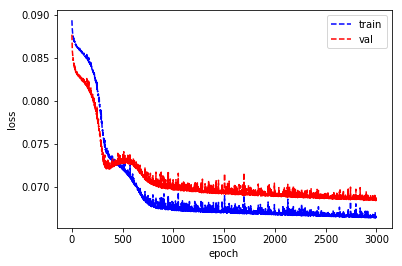

In [17]:
ax = plt.subplot(111)
ax.plot(np.arange(len(loss_train)), loss_train, 'b--')
ax.plot(np.arange(len(loss_val)), loss_val, 'r--')

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_yscale("log")

ax.legend(["train","val"])
ax.figure.savefig("appendix 4-15-15-2 all-atom and h2t series latent space error.jpg")
plt.draw()

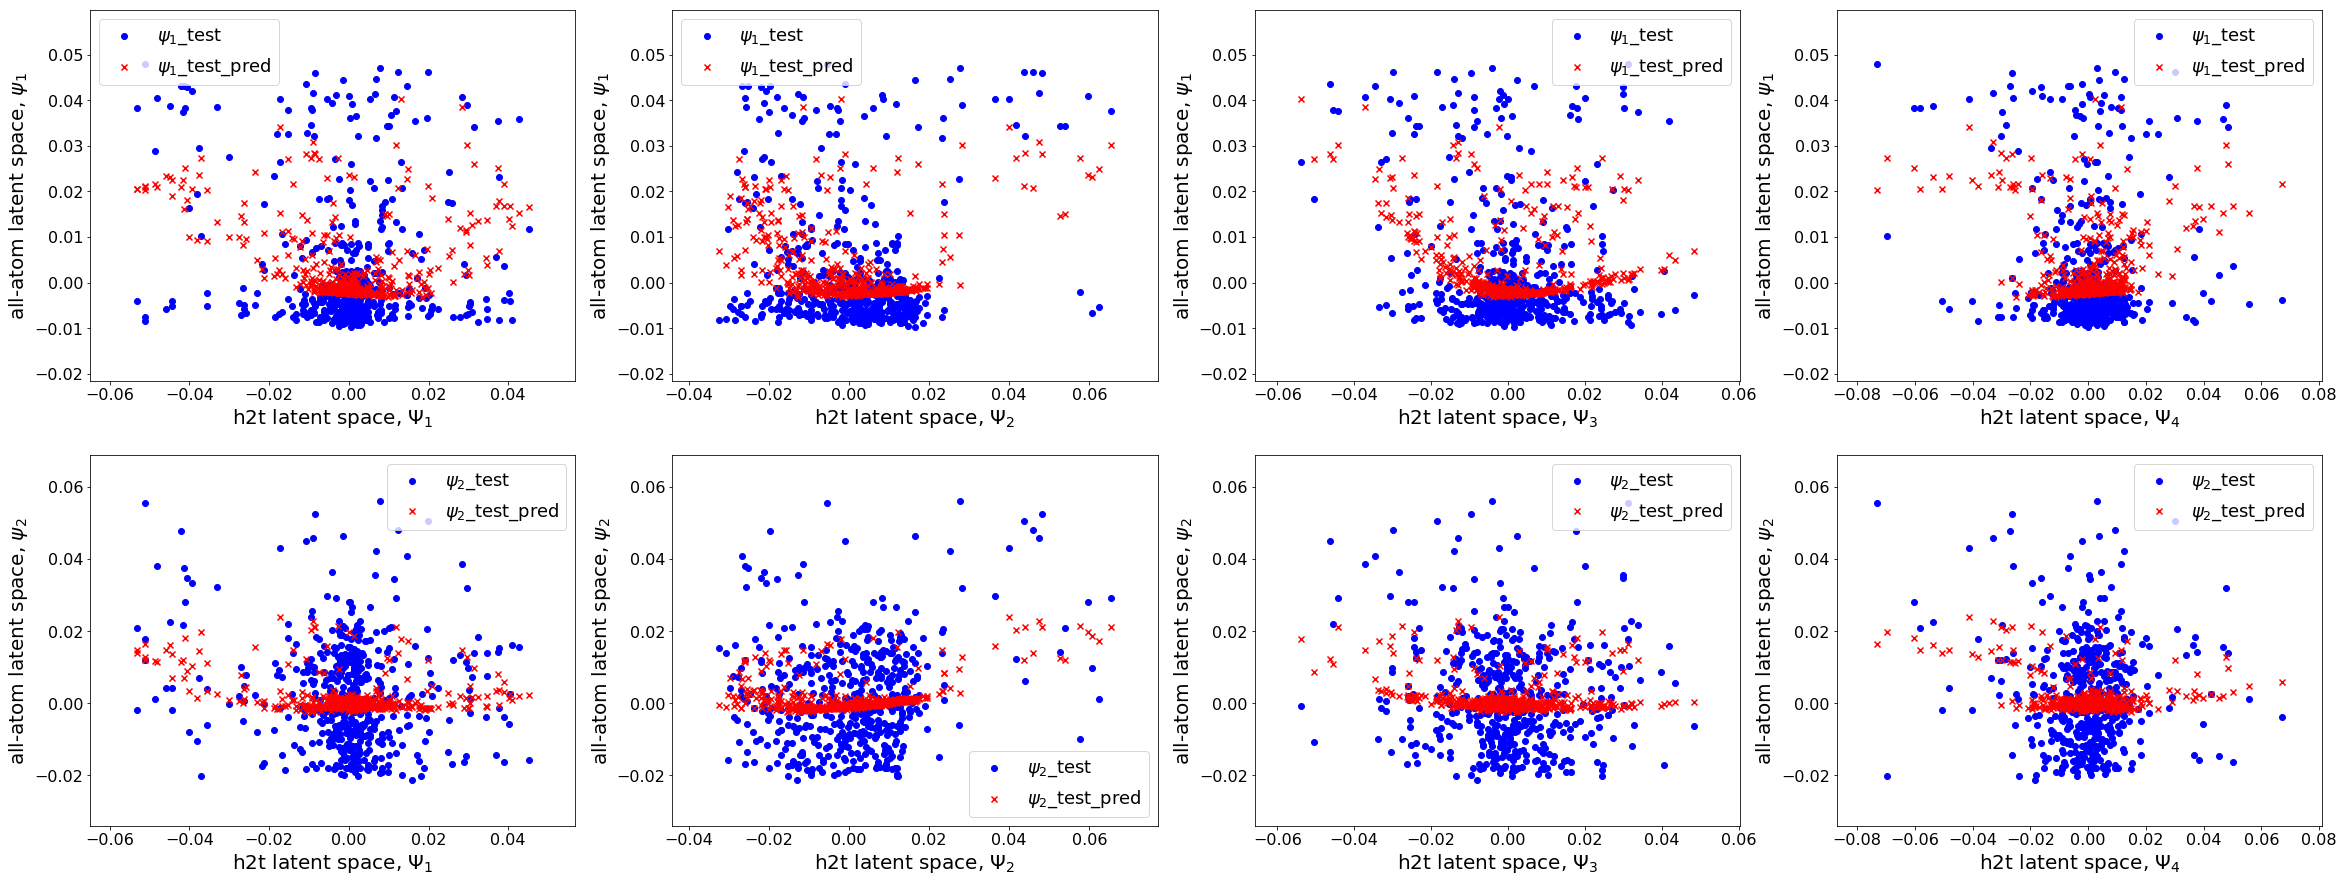

In [18]:
plt.figure(figsize=(40,15))

ax1 = plt.subplot(241)
ax1.scatter(x_test[:,0], y_test[:,0], c='blue', marker='o')
ax1.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax1.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax1.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax1.tick_params(labelsize=16)
ax1.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax2 = plt.subplot(242)
ax2.scatter(x_test[:,1], y_test[:,0], c='blue', marker='o')
ax2.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax2.set_xlabel('h2t latent space, $\Psi_2$',fontsize=20)
ax2.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax2.tick_params(labelsize=16)
ax2.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax3 = plt.subplot(243)
ax3.scatter(x_test[:,2], y_test[:,0], c='blue', marker='o')
ax3.scatter(x_test[:,2], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax3.set_xlabel('h2t latent space, $\Psi_3$',fontsize=20)
ax3.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax3.tick_params(labelsize=16)
ax3.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax4 = plt.subplot(244)
ax4.scatter(x_test[:,3], y_test[:,0], c='blue', marker='o')
ax4.scatter(x_test[:,3], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax4.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax4.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax4.tick_params(labelsize=16)
ax4.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax5 = plt.subplot(245)
ax5.scatter(x_test[:,0], y_test[:,1], c='blue', marker='o')
ax5.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax5.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax5.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax5.tick_params(labelsize=16)
ax5.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax6 = plt.subplot(246)
ax6.scatter(x_test[:,1], y_test[:,1], c='blue', marker='o')
ax6.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax6.set_xlabel('h2t latent space, $\Psi_2$',fontsize=20)
ax6.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax6.tick_params(labelsize=16)
ax6.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)


ax7 = plt.subplot(247)
ax7.scatter(x_test[:,2], y_test[:,1], c='blue', marker='o')
ax7.scatter(x_test[:,2], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax7.set_xlabel('h2t latent space, $\Psi_3$',fontsize=20)
ax7.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax7.tick_params(labelsize=16)
ax7.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax8 = plt.subplot(248)
ax8.scatter(x_test[:,3], y_test[:,1], c='blue', marker='o')
ax8.scatter(x_test[:,3], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax8.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax8.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax8.tick_params(labelsize=16)
ax8.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax.figure.savefig("appendix 4-15-15-2 all-atom and h2t series latent space correspondence.jpg")
plt.draw()